<a href="https://colab.research.google.com/github/dreamcrazier/ST5229_Final_Report/blob/main/Depthwise_Separable_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Depthwise Separable Convolutions

MobileNetV1 and V2 are both based on the method called Depthwise separable convolution, which is widely used in deep learning models for mobile and embedded systems, is a form of factorized convolutions which factorize a standard convolution into a kxk depthwise convolution and a 1x1 convolution called a pointwise convolution. \\
The depthwise convolution applies a single filter to each input channel. The pointwise convolution then applies a 1x1 convolution to combine the outputs the depthwise convolution. (MobileNetV2,2018) The overall process of depthwise separable convolution is shown in the figure below, it could be explained in two steps.

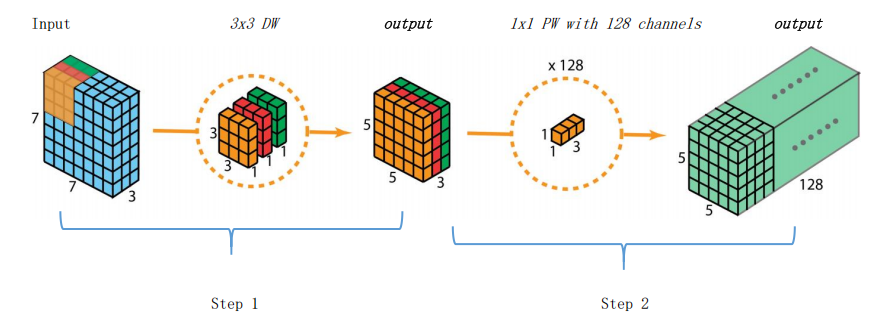 \\
source: https://blog.csdn.net/shiner_chen/article/details/124319246

Let's illustate the method by an example. Assume we have an 7x7x3 input. \\
First let me clarify the phases: DW stands for depthwise, PW stands for pointwise(1x1). In the whole process, a standard convolution will use a 2D-3x3x3x128 kernel, and finally get a 5x5x128 output. \\
However, DW separable convolutions seperate this process in two steps:  \\
Step 1, map the 7x7x3 input into 5x5x3 output using three 3x3x1 DW kernel. in this step, the input is seperated by its channels, in this example, it is seperated to three 7x7x1 input. Each input has a matched kxkx1 kernel, in this example, three 3x3x1 kernels. And we handle the process channel by channel, that is, map the first channel 7x7x1 input into 5x5x1 input by the first channel 3x3x1 DW kernel, and then the second and the third. Finally we stack these three 5x5x1 together ordered by channel. This process maps the information in just 2-dimension(height&width) without the information in depth. \\
Step 2, map this output into one-channel feature map using a 1x1 pointwise convolution kernel, we could set the PW kernel amount according to the output channel size we want. This process is just like what the standard convolution do, in this example, it is mapping the 5x5x3 input into a 5x5x1 feature map. We could also modify depth by applying multiple PW convolutions, in this example, after applying 128 1x1 convolutions, the output size become 5x5x128. \\
With these two steps, depthwise separable convolution also transform the input layer (7 x 7 x 3) into the output layer (5 x 5 x 128).

We could compare the computation costs between standard convolution computational cost, i.e.:
$$Cost = \text{times of doing convolution once} * \text{elements of the output feature map}$$ \\
For standard convolution,
$$Cost_{SC} = (D_k ⋅ D_k ⋅ M) \cdot (N ⋅ D_F ⋅ D_F)$$
Where $M$ is the input channels, $D_k$ is the height&width of the kernel, $N$ is the output channels, $D_F$ is the height&width of the output. \\
And the parameter amount is $(D_k ⋅ D_k ⋅ M ⋅ N)$ \\

For depthwise separable convolution,
$$Cost_{DWSC} = (D_k ⋅ D_k ⋅ M ⋅ D_F ⋅ D_F) + (M ⋅ N ⋅ D_F ⋅ D_F)$$ \\

And the parameter amount is $(D_k ⋅ D_k ⋅ M) + (1 ⋅ 1 ⋅ M ⋅ N)$ \\

Comparison:
$$ {Cost_{SC} \over Cost_{DWSC}}  = {{(D_k ⋅ D_k ⋅ M) \cdot (N ⋅ D_F ⋅ D_F)} \over {(D_k ⋅ D_k ⋅ M ⋅ D_F ⋅ D_F) + (M ⋅ N ⋅ D_F ⋅ D_F)}} = { {1 \over N}+{1 \over D_k^2} }$$ \\
In the 3x3 DW, that is, in the MobileNetV2 case, the computation cost decrease around 9 times than that in the standard convolution.

In [ ]:
import torch
import torch.nn as nn
'''
in_channel, in_channels: input channels;
out_channel, out_channels: output channels;
groups: Control of the grouping convolution, defaults to 1. This parameter determines whether the input and output channels are convolved into groups;
    groups=1, standard convolution, groups=in_channel:depthwise convolution.
'''

class DepthWiseConv(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(DepthWiseConv, self).__init__()

        # Step 1: Convolution by input channel
        self.depth_conv = nn.Conv2d(in_channels=in_channel,
                                    out_channels=in_channel,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1,
                                    groups=in_channel)



        #Step 2: Pointwise convolution
        self.point_conv = nn.Conv2d(in_channels=in_channel,
                                    out_channels=out_channel,
                                    kernel_size=1,
                                    stride=1,
                                    padding=0,
                                    groups=1)



        def forward(self,input):
              out = self.depth_conv(input)
              out = self.point_conv(out)
              return out



In addition, MobileNetV2 introduces hyperparameters $\alpha$ and $\rho$ explained as below. \\
$$Cost_{DWSC} = (D_k ⋅ D_k ⋅ αM ⋅ ρD_F ⋅ \rho D_F) + (\alpha M ⋅ \alpha N ⋅ \rho D_F ⋅ \rho D_F)$$ \\
Where $\alpha$ controls the width of the net, to be more specific, is M and N, which means the amount of the input and output channels, i.e. amount of the kernels. \\
$\alpha$ provides a trade-off between the model size and its computational performance. A larger $\alpha$ will increase the accuracy potential of the network by providing more capacity (larger number of kernels or channels), but at the cost of increased computation and memory usage. \\
* If $\alpha$ = 1 (i.e., no scaling), the number of input channels M and output channels N would remain the same as originally specified in the layer.

* If $\alpha$ = 0.5, the number of input and output channels would be halved, reducing the model's capacity but also reducing the computational requirements. \\

$\rho$ controls the output size, and indirectly controls the size of internel feature map. This in turn affects the computing and memory requirements of the network. By controlling $\rho$, the complexity of the network can be effectively adjusted, especially when dealing with large inputs



In MobileNetV2, the DW layer and PW layer in the depthwise convolution block are both followed by a batch and ReLU, which are the same as the standard convolution. \\



In [ ]:
#The sample code of the block

import tensorflow as tf
from tensorflow.keras import layers

def depthwise_conv_block(inputs, pointwise_conv_filters, alpha, depth_multiplier=1, strides=(1, 1), block_id=1):
    if strides == (1, 1):
        x = inputs
    else:
        x = layers.ZeroPadding2D(((0, 1), (0, 1)), name='conv_pad_%d' % block_id)(inputs)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D((3, 3), padding='same' if strides == (1, 1) else 'valid',
                               depth_multiplier=depth_multiplier, strides=strides, use_bias=False,
                               name='conv_dw_%d' % block_id)(x)

    # Batch Normalization
    x = layers.BatchNormalization(axis=-1, name='conv_dw_bn_%d' % block_id)(x)

    # ReLU6 Activation
    x = layers.ReLU(6., name='conv_dw_relu_%d' % block_id)(x)

    # Pointwise Convolution (1x1 Convolution)
    x = layers.Conv2D(pointwise_conv_filters, (1, 1), padding='same', use_bias=False,
                      name='conv_pw_%d' % block_id)(x)

    # Batch Normalization after Pointwise Convolution
    x = layers.BatchNormalization(axis=-1, name='conv_pw_%d_bn' % block_id)(x)

    # ReLU6 Activation after Pointwise Convolution
    x = layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

    return x


The key difference is that MobileNetV2 uses ReLU6 instead of the standard ReLU. ReLU has an output range of [0, +∞), where all positive values are activated linearly. In contrast, ReLU6 limits the output to the range [0, 6]. This limitation is introduced to accommodate the lower-performance GPUs typically found in mobile devices. These devices usually perform computations using 8-bit to 16-bit integers, rather than 32-bit or 64-bit floating-point numbers.

With such low-precision representations, ReLU6 has a better effect because it limits larger activation values to 6, thus preventing overflow or precision loss. This allows for more stable and efficient performance when operating under constrained computational resources.

The limitation of simple DW-PW network(MobileNet V1) is obviously. First, the imformation is losing. We could see from the example below:

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Layer: conv1_relu - Activation min: 0.0, max: 6.0


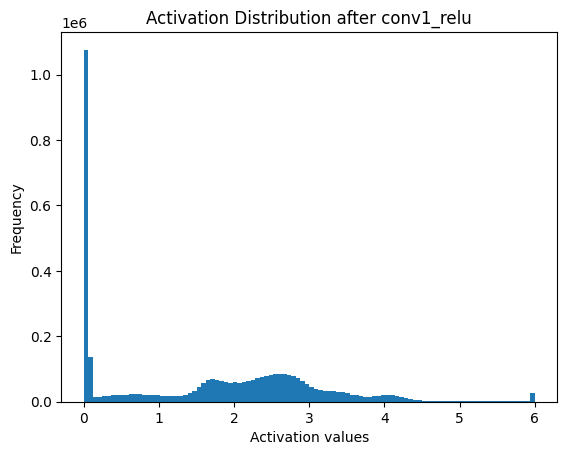

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Layer: conv_dw_1_relu - Activation min: 0.0, max: 6.0


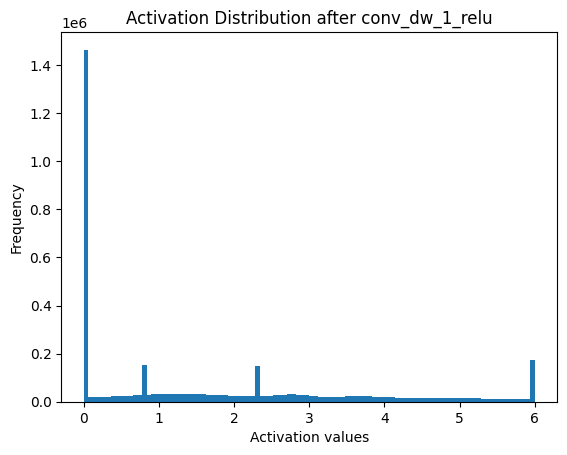

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Layer: conv_pw_1_relu - Activation min: 0.0, max: 6.0


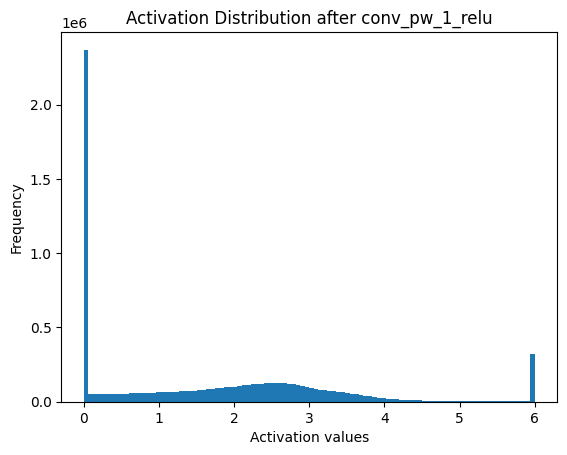

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Layer: conv_dw_2_relu - Activation min: 0.0, max: 6.0


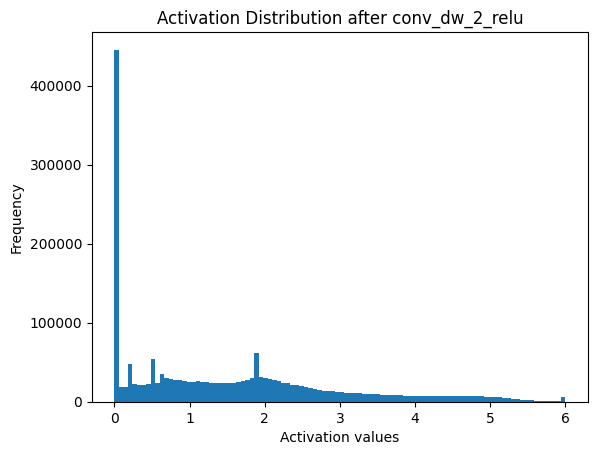

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Layer: conv_pw_2_relu - Activation min: 0.0, max: 6.0


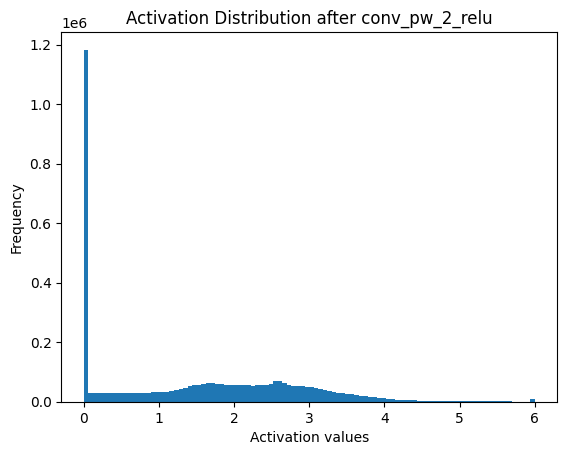

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Layer: conv_dw_3_relu - Activation min: 0.0, max: 6.0


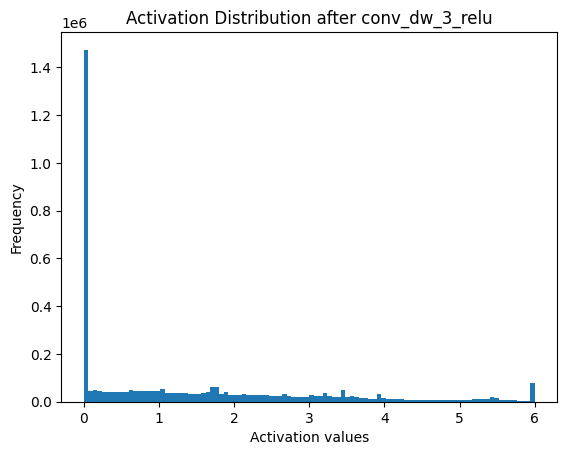

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Layer: conv_pw_3_relu - Activation min: 0.0, max: 6.0


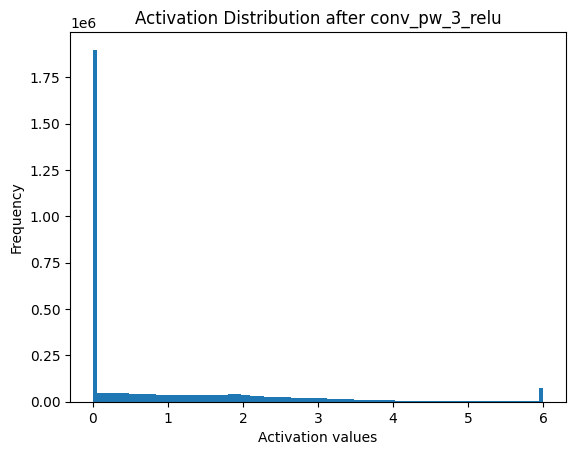

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Layer: conv_dw_4_relu - Activation min: 0.0, max: 6.0


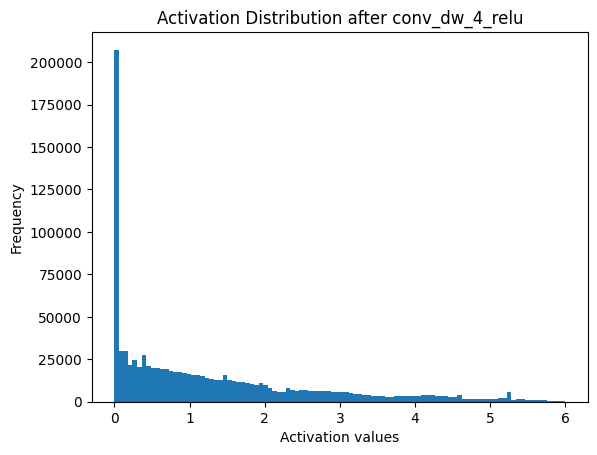

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Layer: conv_pw_4_relu - Activation min: 0.0, max: 6.0


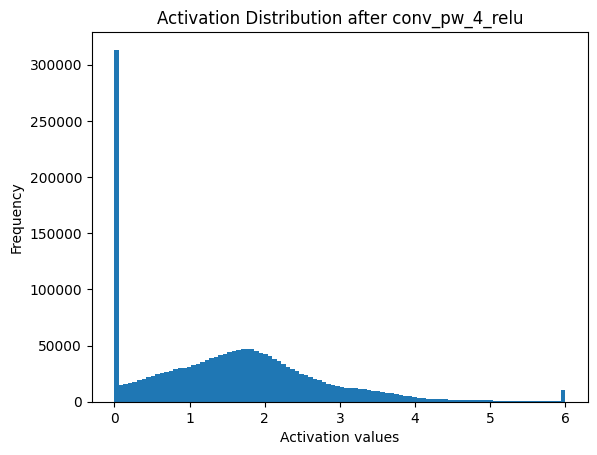

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Layer: conv_dw_5_relu - Activation min: 0.0, max: 6.0


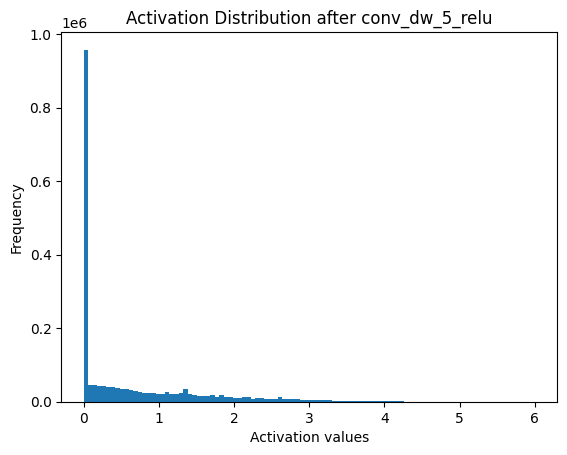

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
Layer: conv_pw_5_relu - Activation min: 0.0, max: 6.0


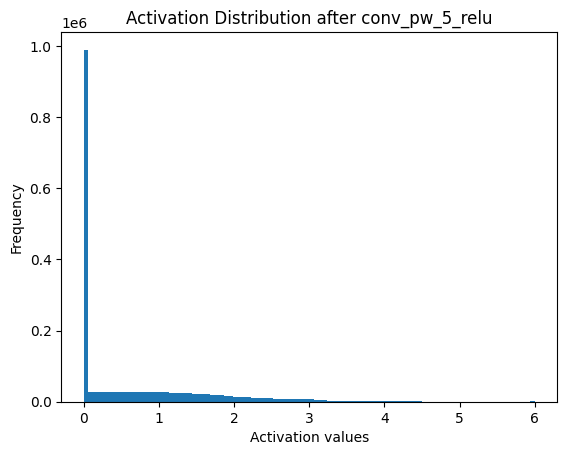

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Layer: conv_dw_6_relu - Activation min: 0.0, max: 6.0


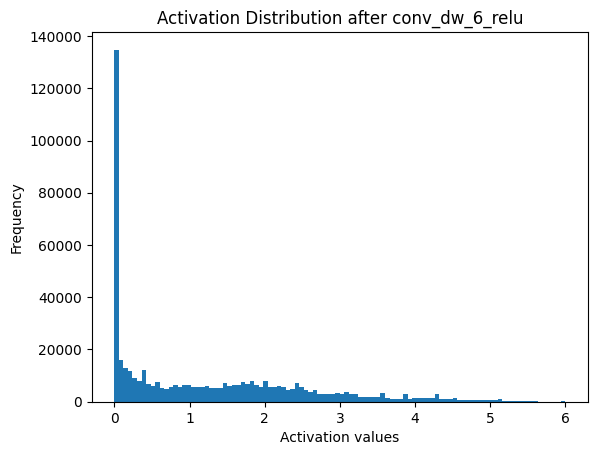

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Layer: conv_pw_6_relu - Activation min: 0.0, max: 6.0


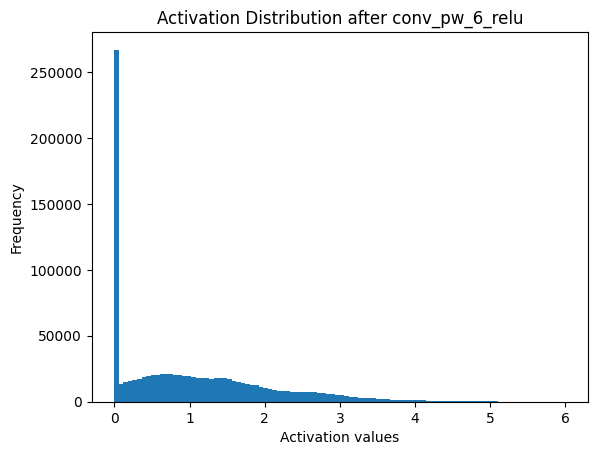

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
Layer: conv_dw_7_relu - Activation min: 0.0, max: 6.0


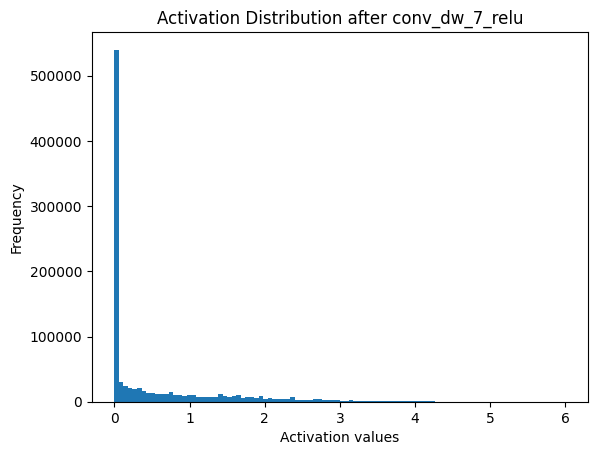

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Layer: conv_pw_7_relu - Activation min: 0.0, max: 6.0


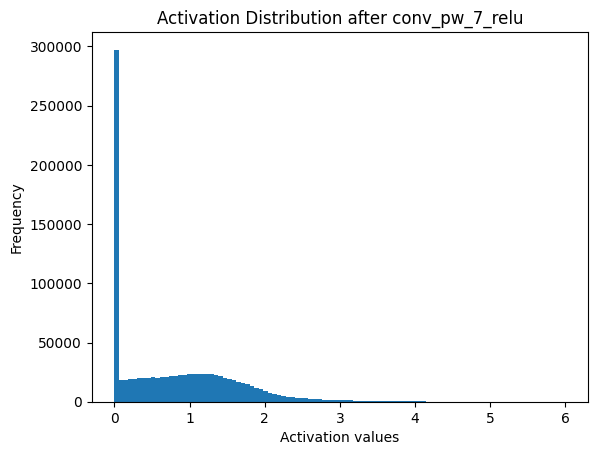

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Layer: conv_dw_8_relu - Activation min: 0.0, max: 6.0


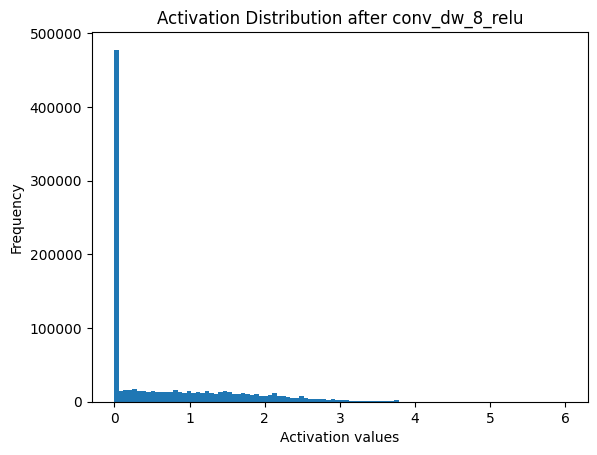

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Layer: conv_pw_8_relu - Activation min: 0.0, max: 6.0


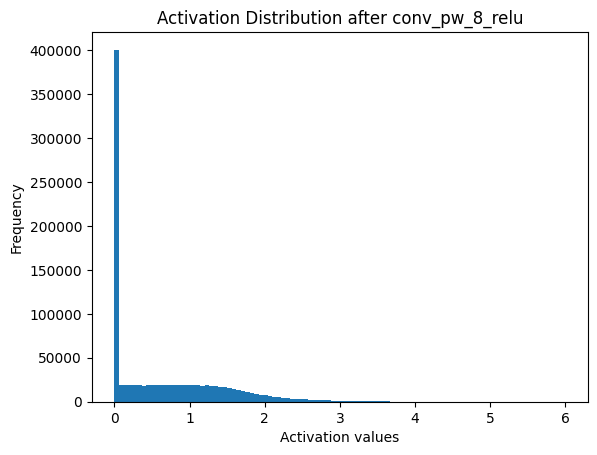

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_dw_9_relu - Activation min: 0.0, max: 6.0


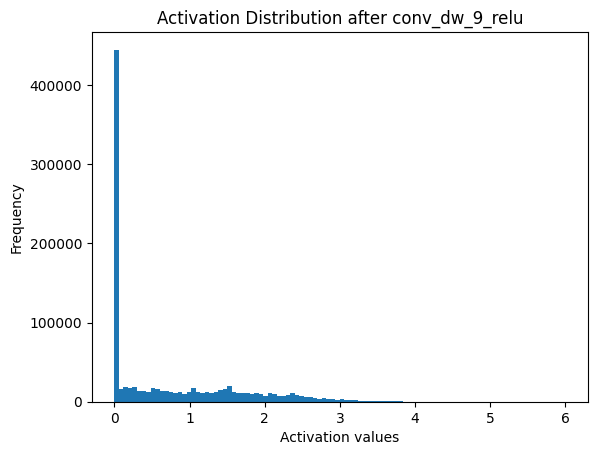

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
Layer: conv_pw_9_relu - Activation min: 0.0, max: 6.0


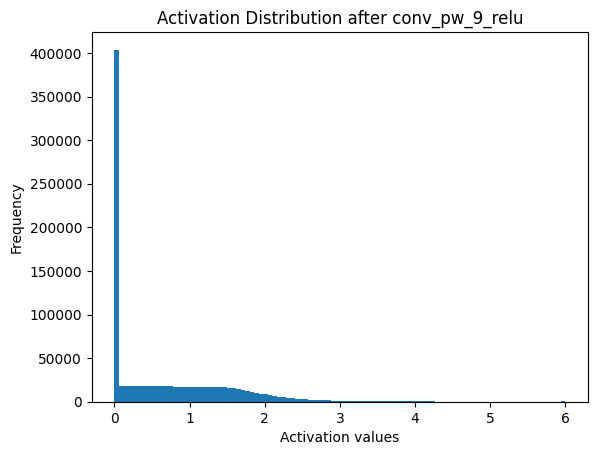

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Layer: conv_dw_10_relu - Activation min: 0.0, max: 6.0


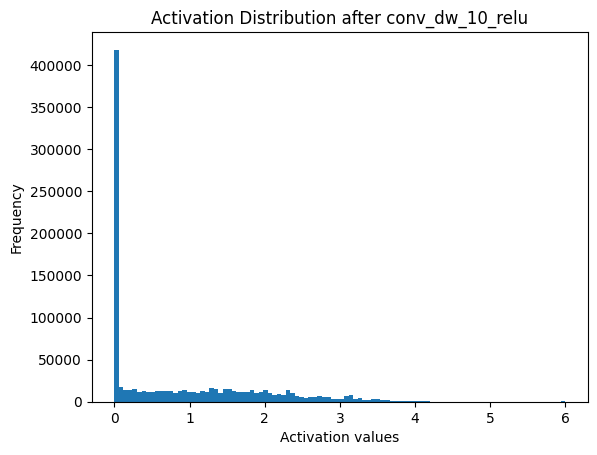

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Layer: conv_pw_10_relu - Activation min: 0.0, max: 6.0


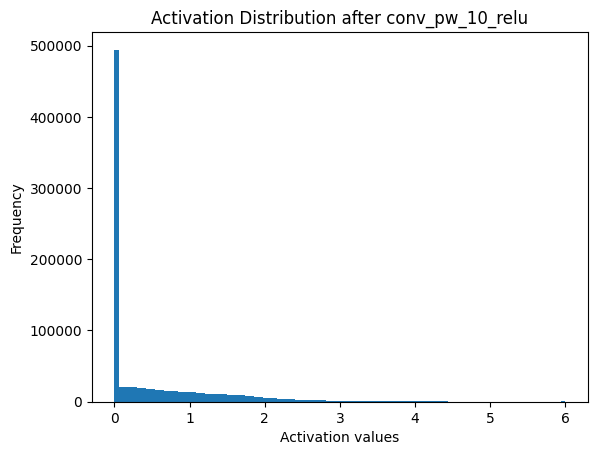

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Layer: conv_dw_11_relu - Activation min: 0.0, max: 6.0


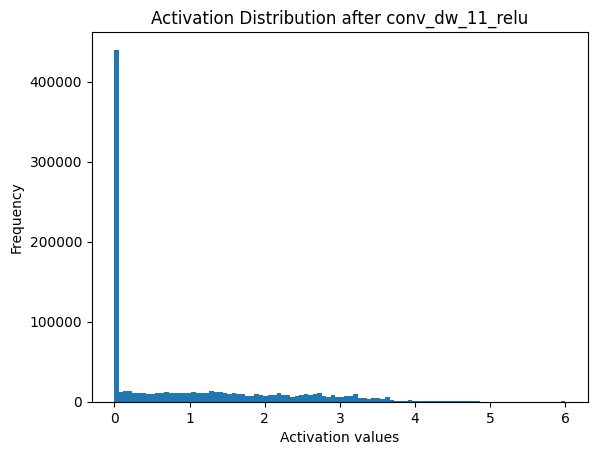

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
Layer: conv_pw_11_relu - Activation min: 0.0, max: 6.0


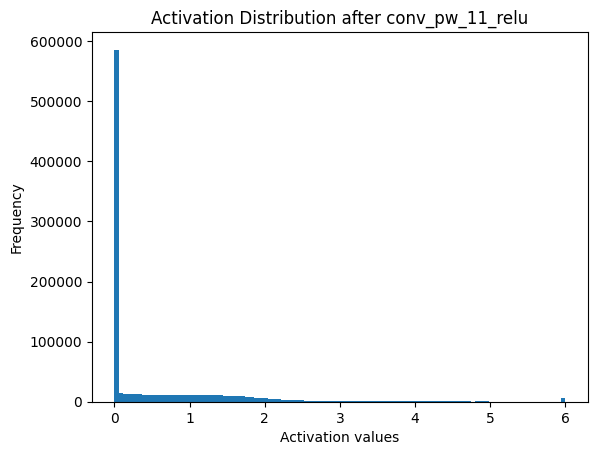

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
Layer: conv_dw_12_relu - Activation min: 0.0, max: 6.0


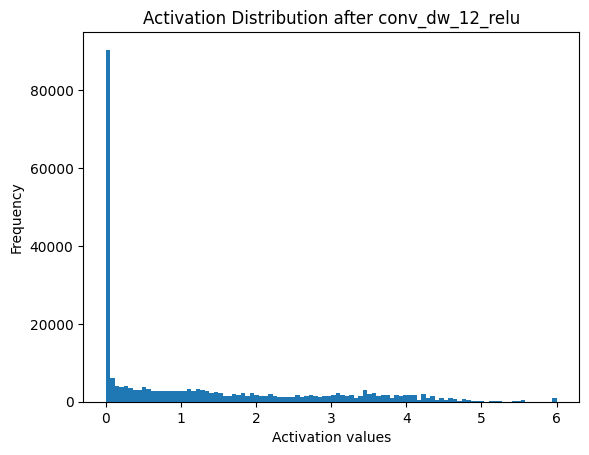

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
Layer: conv_pw_12_relu - Activation min: 0.0, max: 6.0


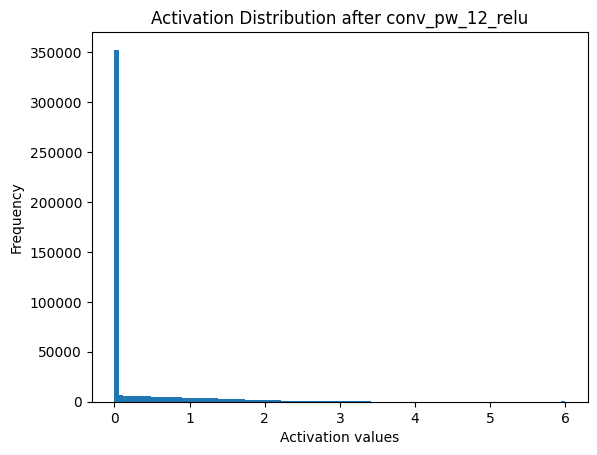

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_dw_13_relu - Activation min: 0.0, max: 6.0


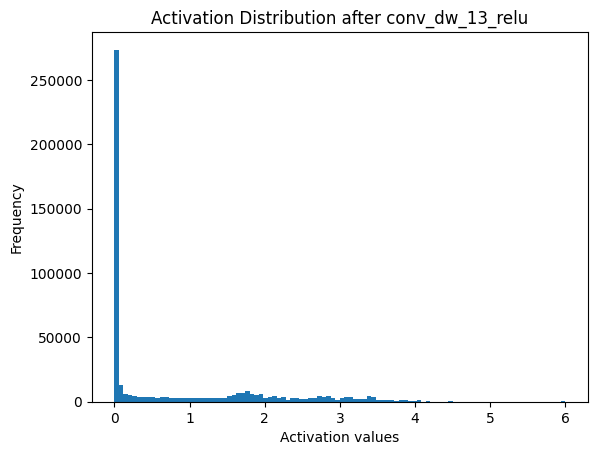

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
Layer: conv_pw_13_relu - Activation min: 0.0, max: 6.0


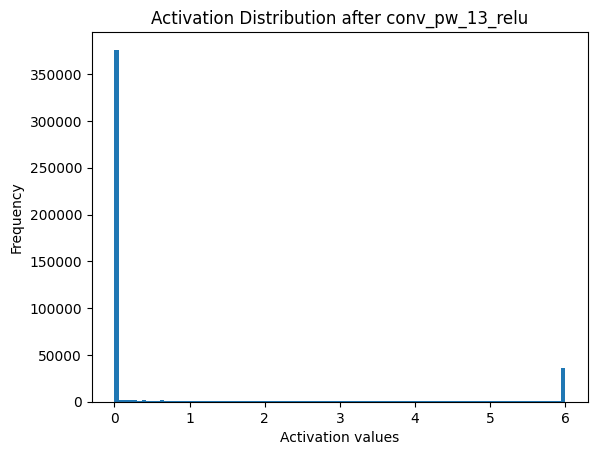

4/4 ━━━━━━━━━━━━━━━━━━━━ 73s 15s/step - accuracy: 0.0000e+00 - loss: 9.4403
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Layer: conv1_relu - Activation min: 0.0, max: 6.0


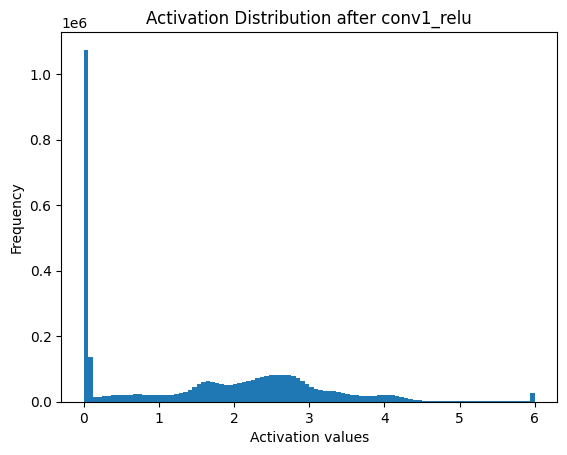

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Layer: conv_dw_1_relu - Activation min: 0.0, max: 6.0


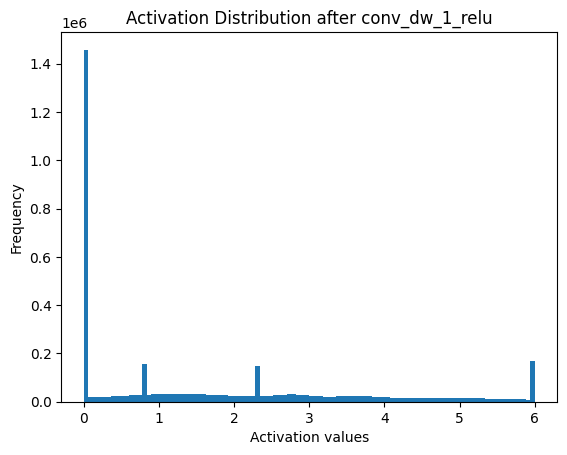

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Layer: conv_pw_1_relu - Activation min: 0.0, max: 6.0


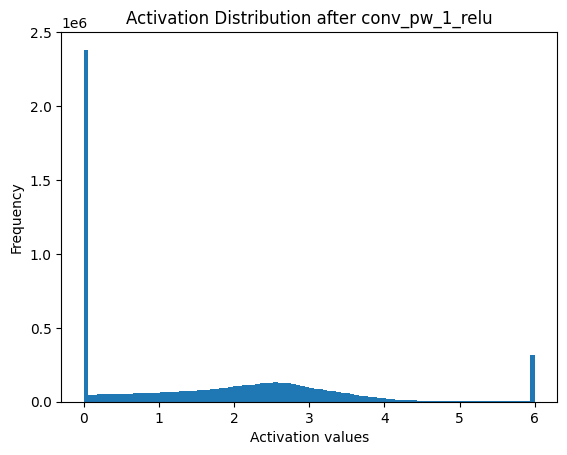

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Layer: conv_dw_2_relu - Activation min: 0.0, max: 6.0


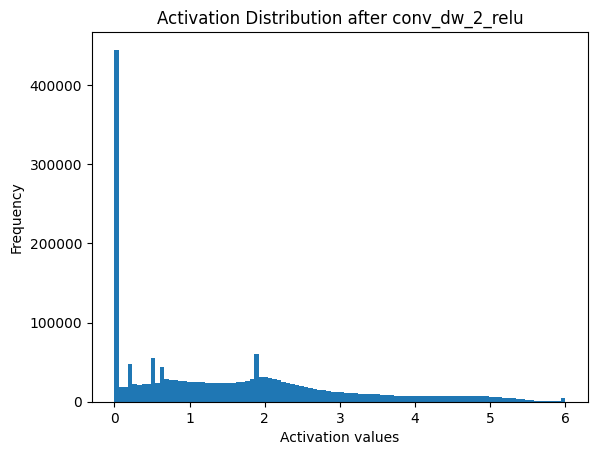

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Layer: conv_pw_2_relu - Activation min: 0.0, max: 6.0


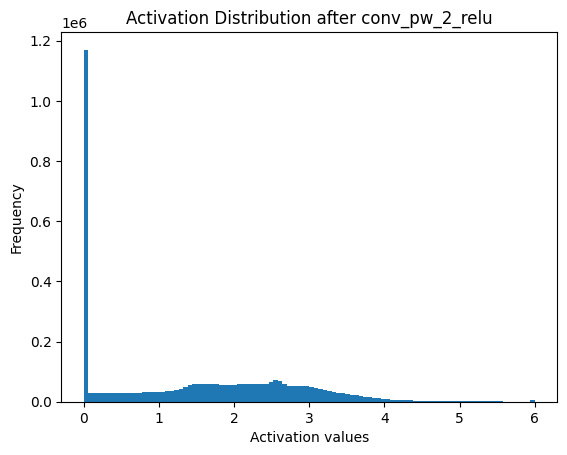

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Layer: conv_dw_3_relu - Activation min: 0.0, max: 6.0


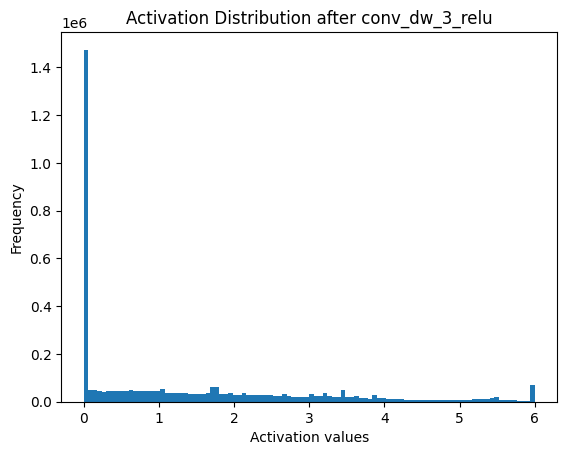

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Layer: conv_pw_3_relu - Activation min: 0.0, max: 6.0


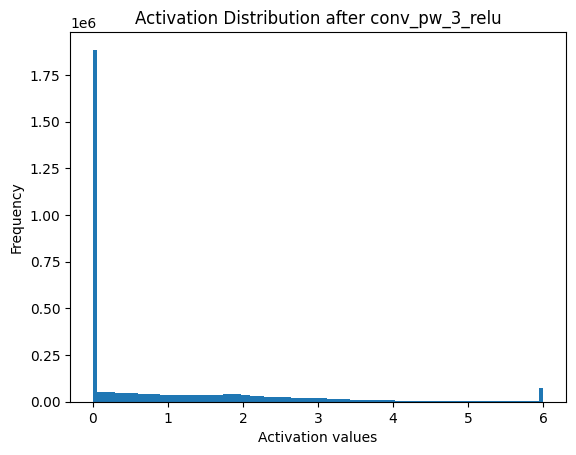

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Layer: conv_dw_4_relu - Activation min: 0.0, max: 6.0


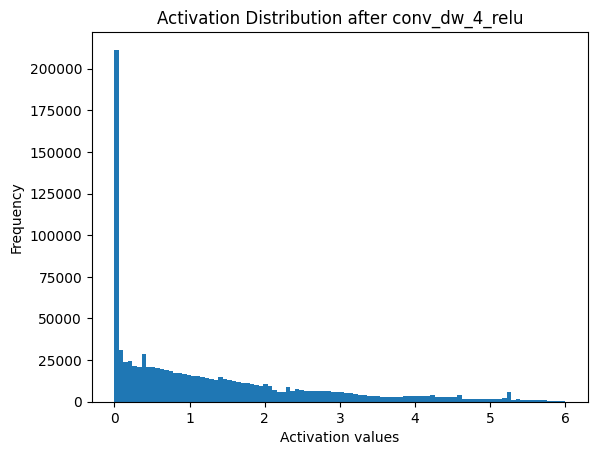

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Layer: conv_pw_4_relu - Activation min: 0.0, max: 6.0


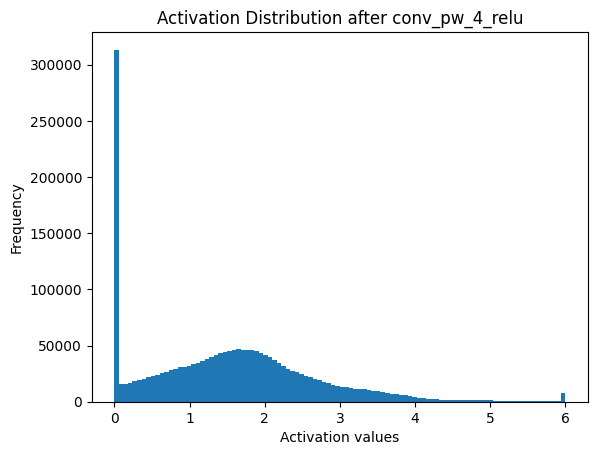

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
Layer: conv_dw_5_relu - Activation min: 0.0, max: 6.0


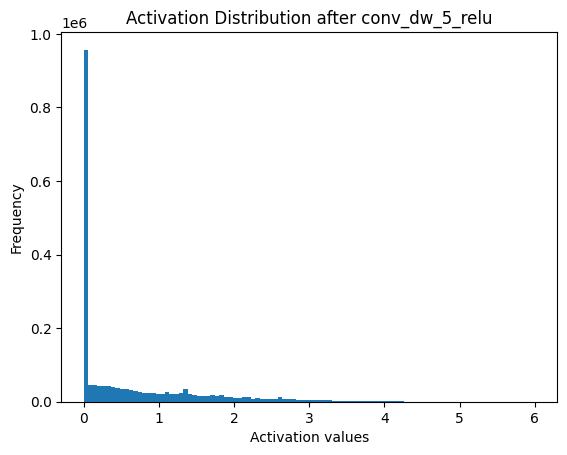

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Layer: conv_pw_5_relu - Activation min: 0.0, max: 6.0


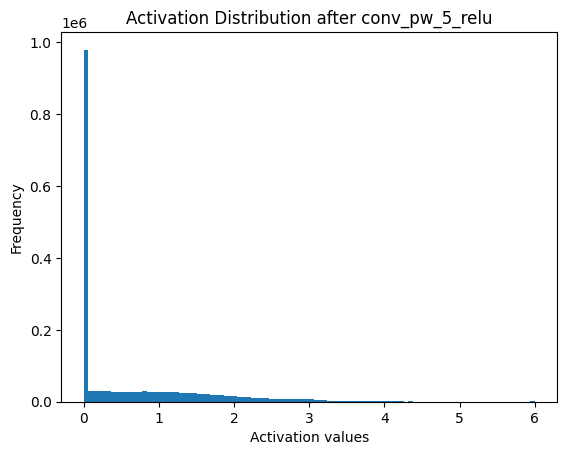

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Layer: conv_dw_6_relu - Activation min: 0.0, max: 6.0


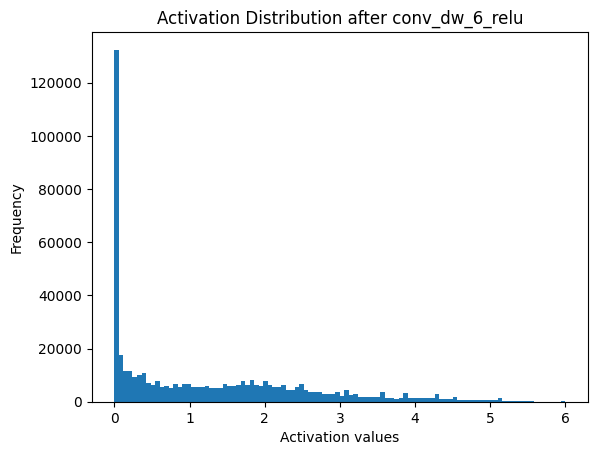

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
Layer: conv_pw_6_relu - Activation min: 0.0, max: 6.0


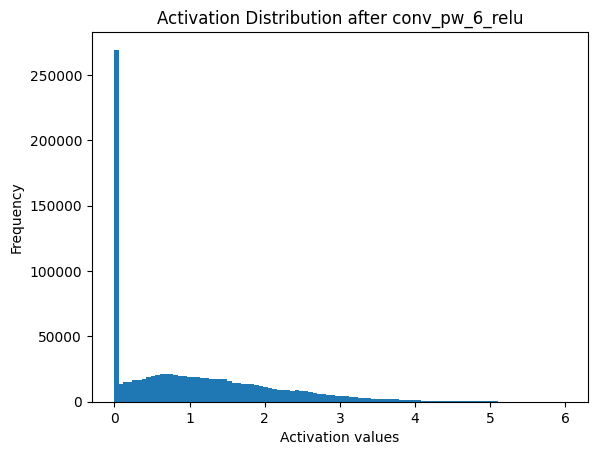

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Layer: conv_dw_7_relu - Activation min: 0.0, max: 6.0


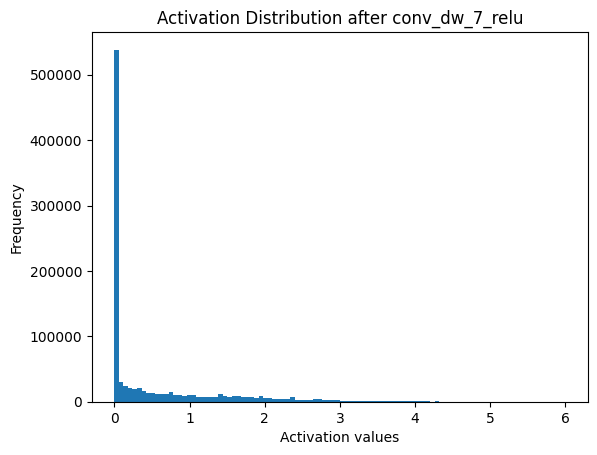

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Layer: conv_pw_7_relu - Activation min: 0.0, max: 6.0


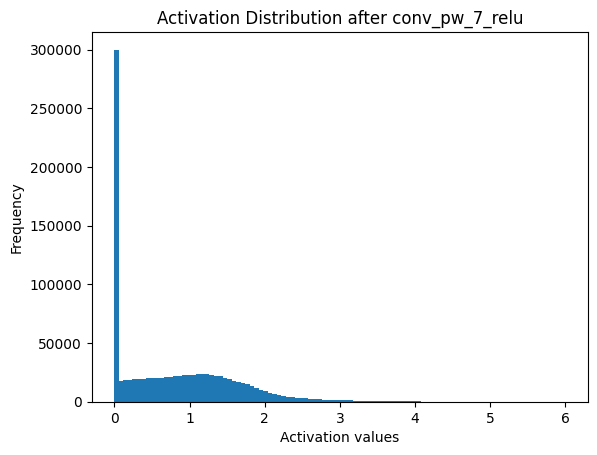

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Layer: conv_dw_8_relu - Activation min: 0.0, max: 6.0


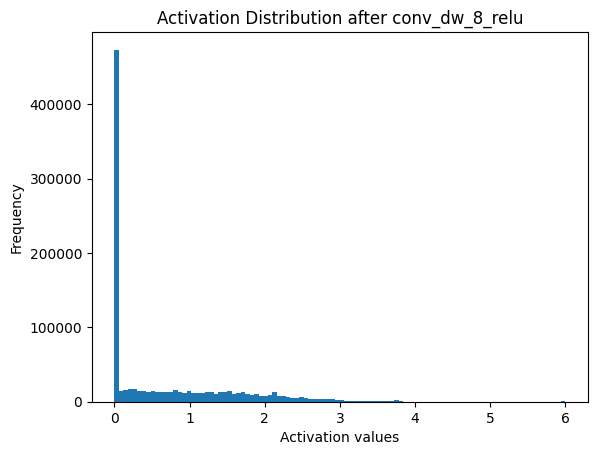

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Layer: conv_pw_8_relu - Activation min: 0.0, max: 6.0


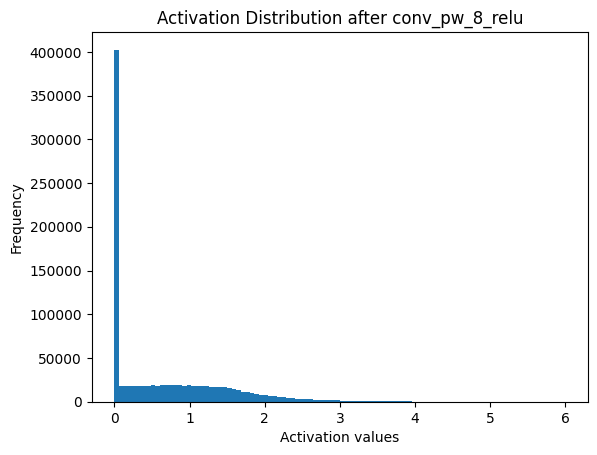

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Layer: conv_dw_9_relu - Activation min: 0.0, max: 6.0


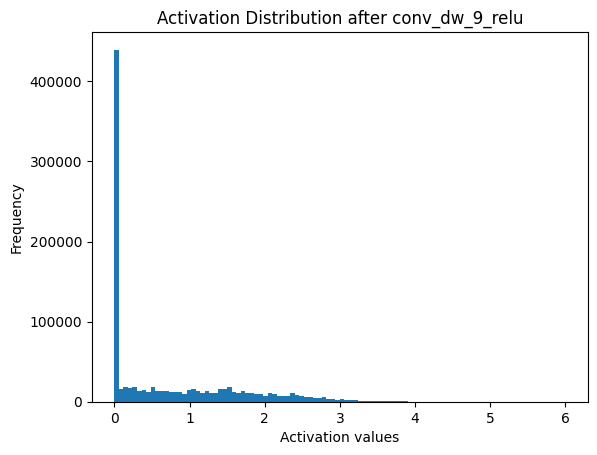

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_pw_9_relu - Activation min: 0.0, max: 6.0


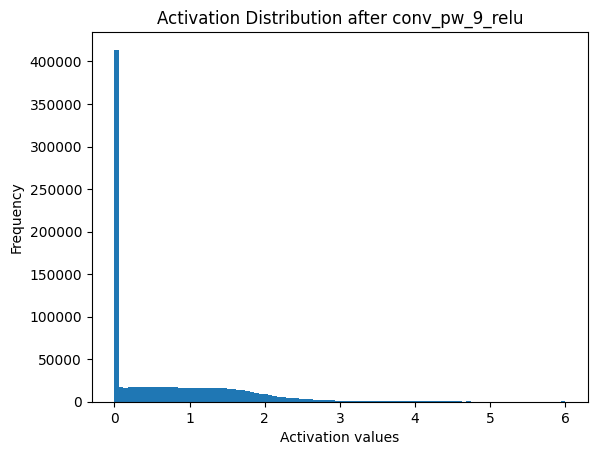

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
Layer: conv_dw_10_relu - Activation min: 0.0, max: 6.0


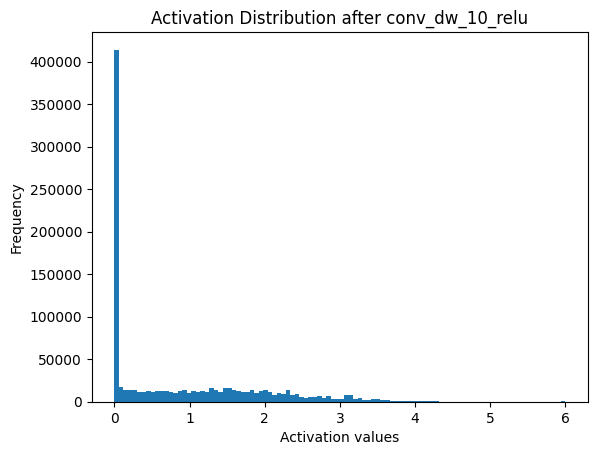

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
Layer: conv_pw_10_relu - Activation min: 0.0, max: 6.0


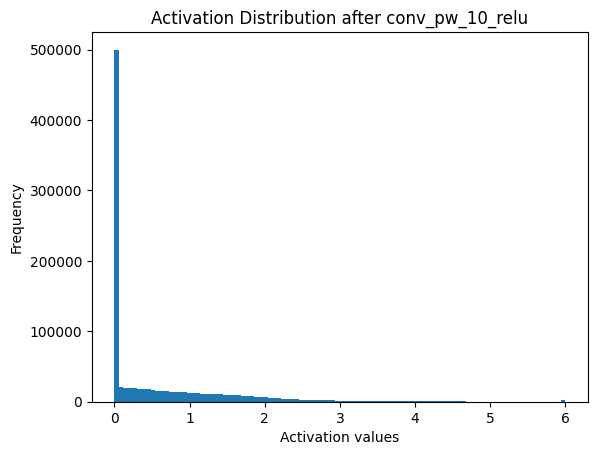

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
Layer: conv_dw_11_relu - Activation min: 0.0, max: 6.0


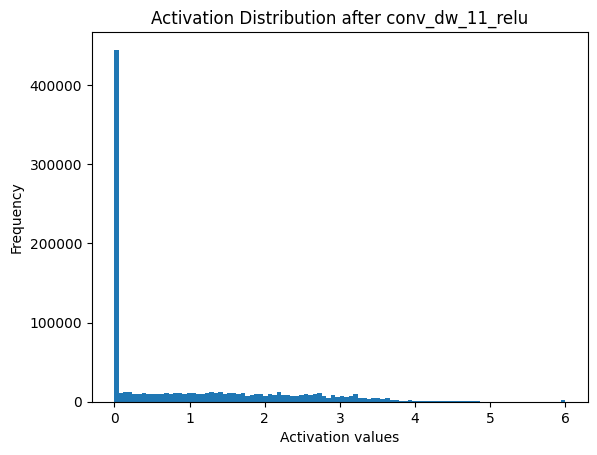

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
Layer: conv_pw_11_relu - Activation min: 0.0, max: 6.0


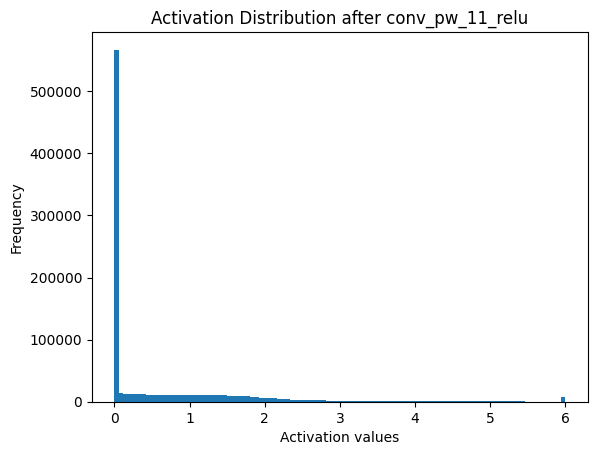

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
Layer: conv_dw_12_relu - Activation min: 0.0, max: 6.0


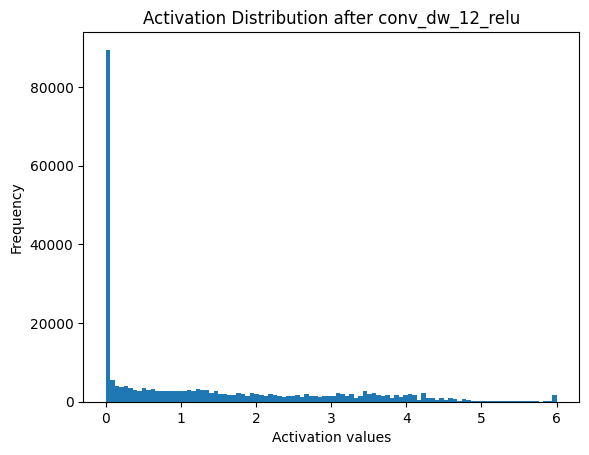

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
Layer: conv_pw_12_relu - Activation min: 0.0, max: 6.0


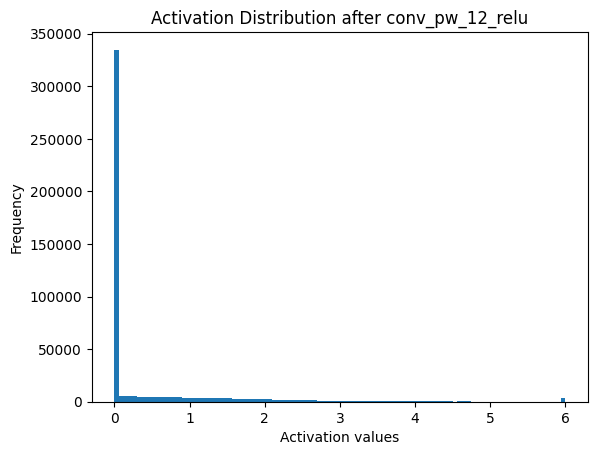

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
Layer: conv_dw_13_relu - Activation min: 0.0, max: 6.0


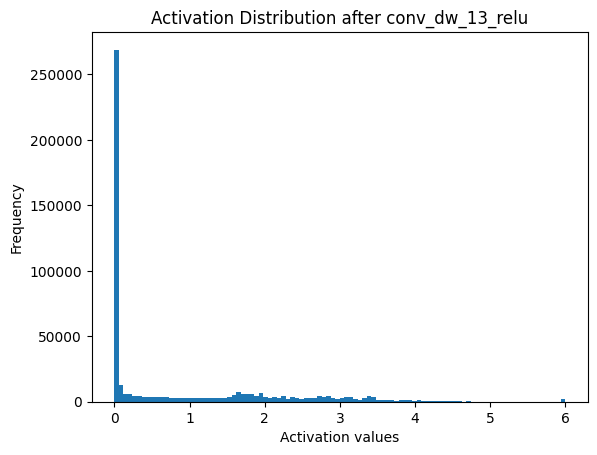

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_pw_13_relu - Activation min: 0.0, max: 6.0


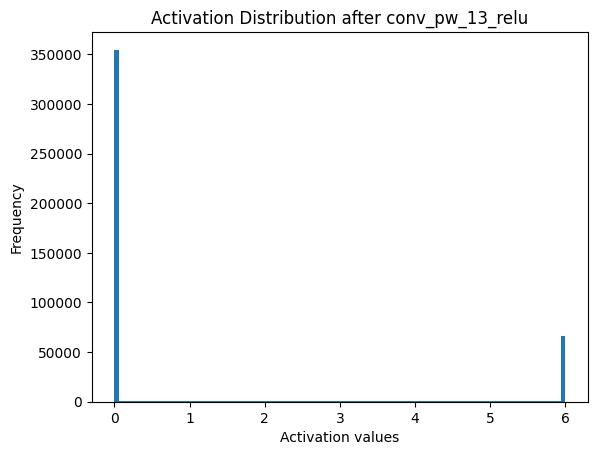

4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 15s/step - accuracy: 1.0000 - loss: 0.0058
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Layer: conv1_relu - Activation min: 0.0, max: 6.0


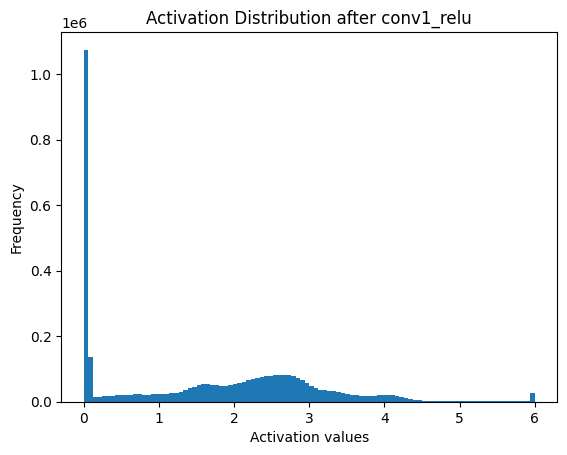

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Layer: conv_dw_1_relu - Activation min: 0.0, max: 6.0


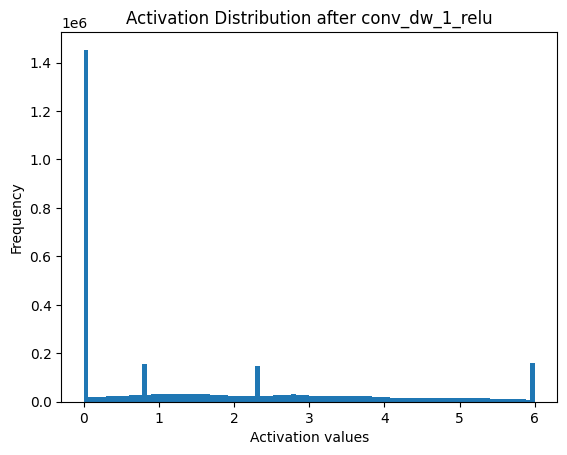

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Layer: conv_pw_1_relu - Activation min: 0.0, max: 6.0


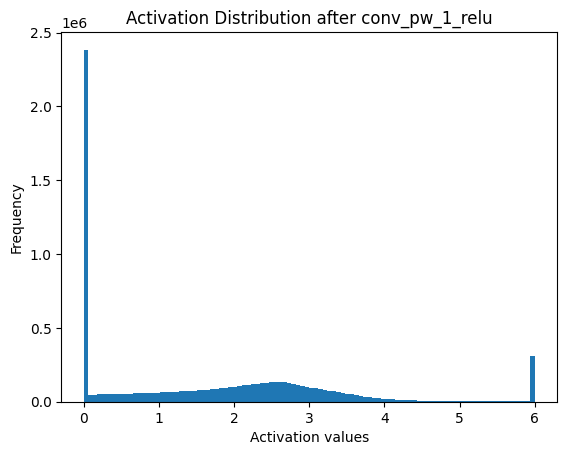

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Layer: conv_dw_2_relu - Activation min: 0.0, max: 6.0


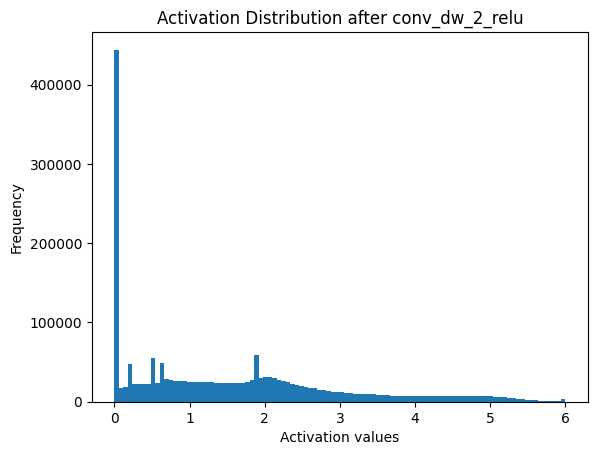

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Layer: conv_pw_2_relu - Activation min: 0.0, max: 6.0


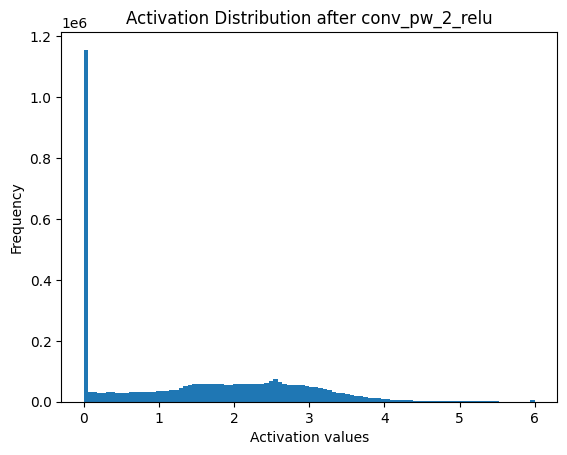

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Layer: conv_dw_3_relu - Activation min: 0.0, max: 6.0


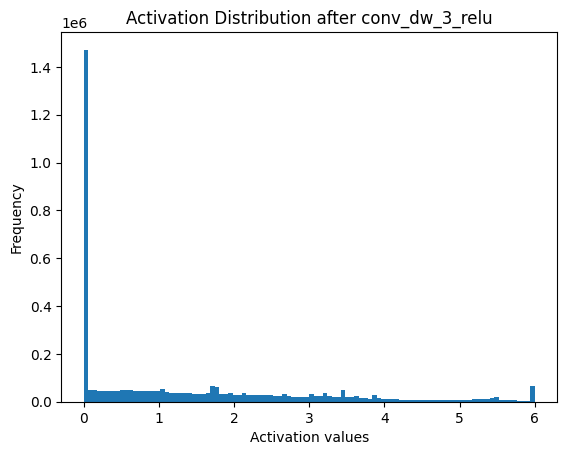

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
Layer: conv_pw_3_relu - Activation min: 0.0, max: 6.0


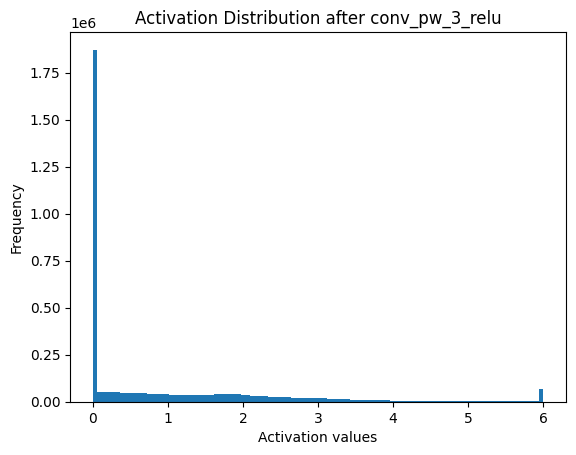

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Layer: conv_dw_4_relu - Activation min: 0.0, max: 6.0


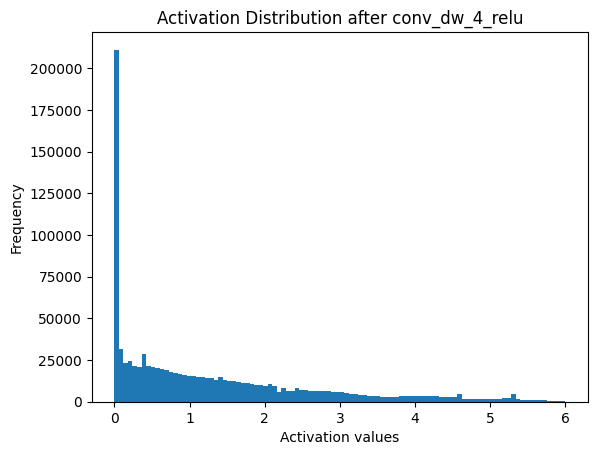

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Layer: conv_pw_4_relu - Activation min: 0.0, max: 6.0


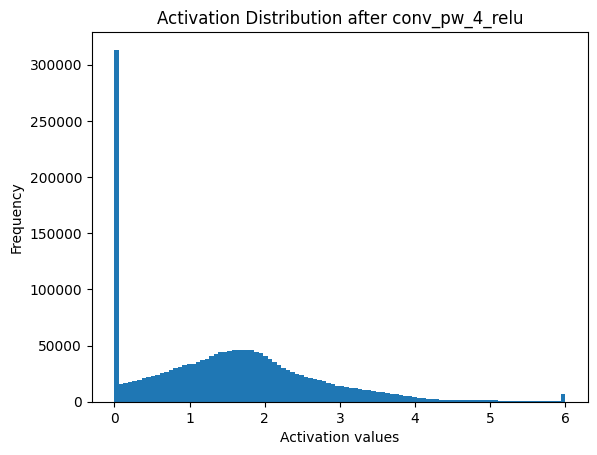

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
Layer: conv_dw_5_relu - Activation min: 0.0, max: 6.0


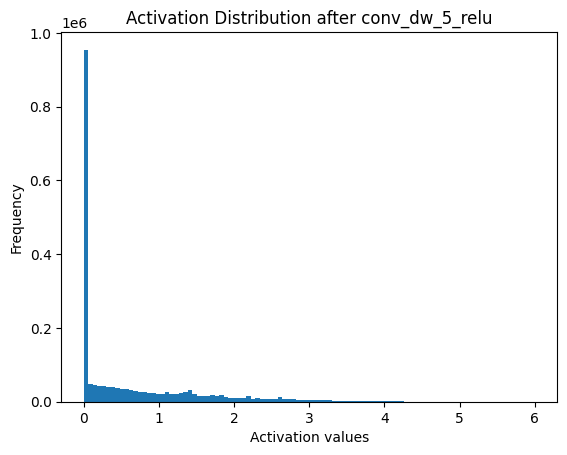

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Layer: conv_pw_5_relu - Activation min: 0.0, max: 6.0


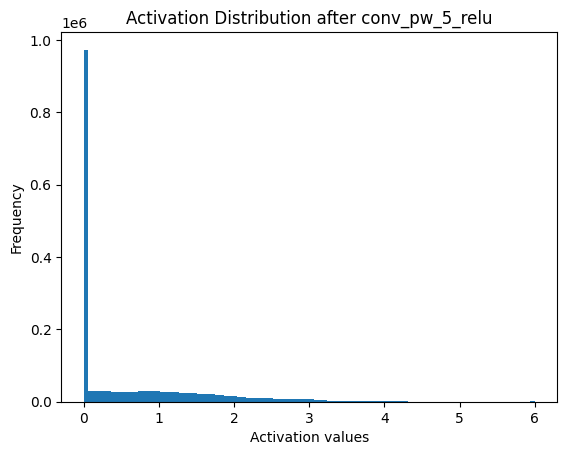

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Layer: conv_dw_6_relu - Activation min: 0.0, max: 6.0


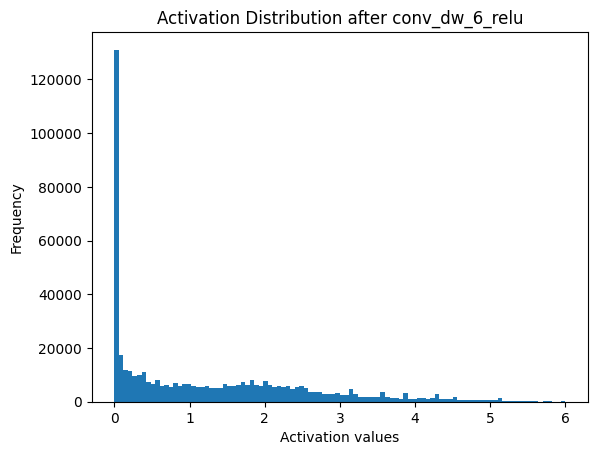

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Layer: conv_pw_6_relu - Activation min: 0.0, max: 6.0


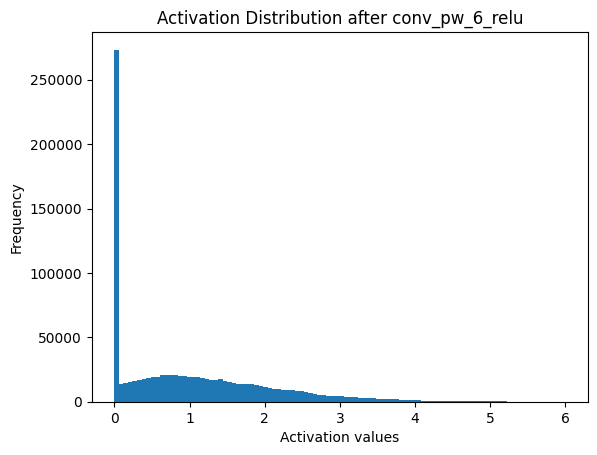

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Layer: conv_dw_7_relu - Activation min: 0.0, max: 6.0


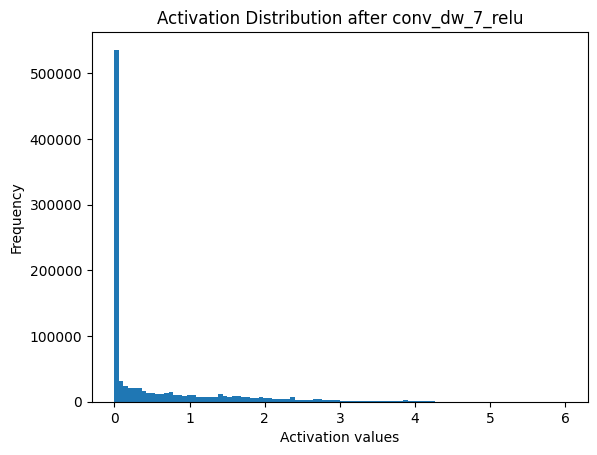

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
Layer: conv_pw_7_relu - Activation min: 0.0, max: 6.0


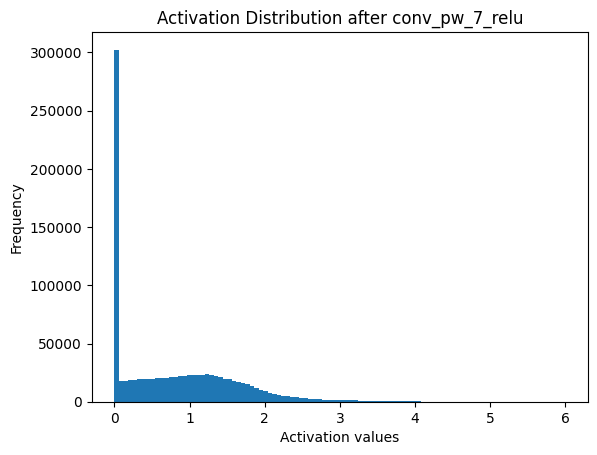

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Layer: conv_dw_8_relu - Activation min: 0.0, max: 6.0


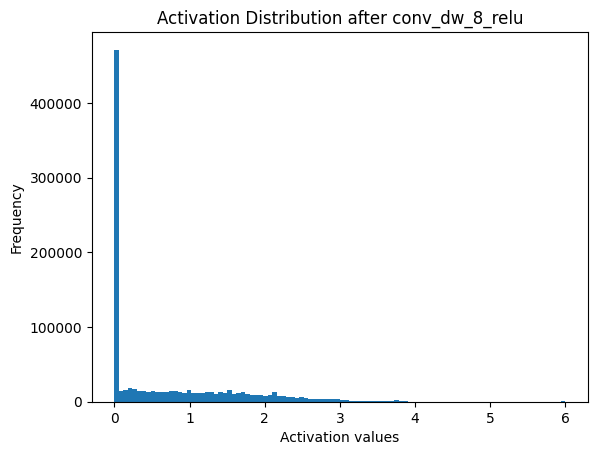

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Layer: conv_pw_8_relu - Activation min: 0.0, max: 6.0


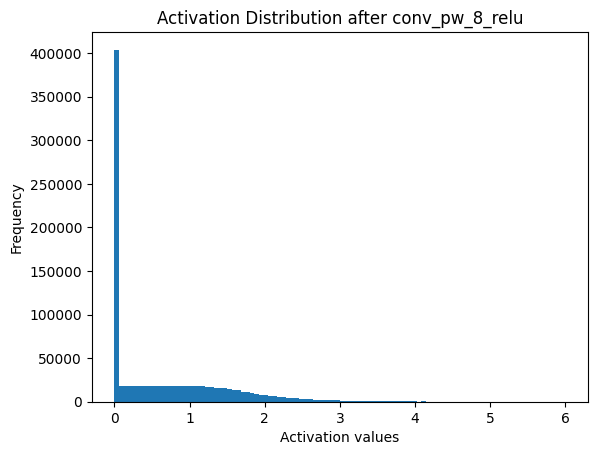

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Layer: conv_dw_9_relu - Activation min: 0.0, max: 6.0


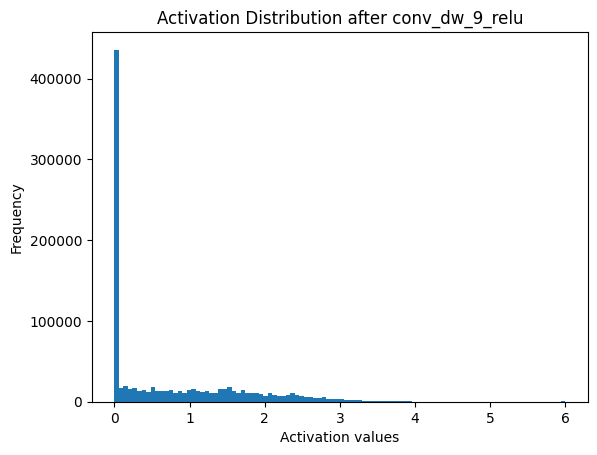

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
Layer: conv_pw_9_relu - Activation min: 0.0, max: 6.0


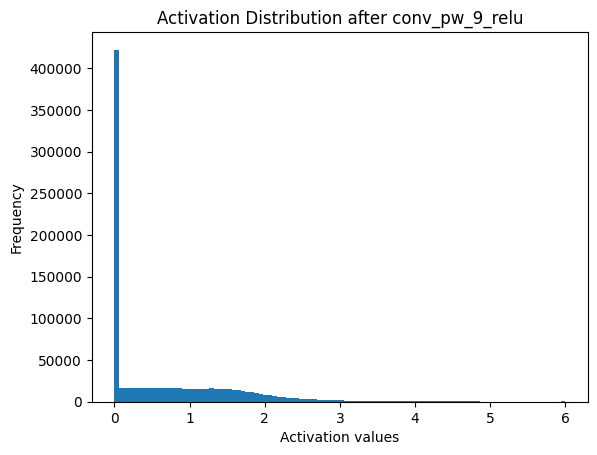

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Layer: conv_dw_10_relu - Activation min: 0.0, max: 6.0


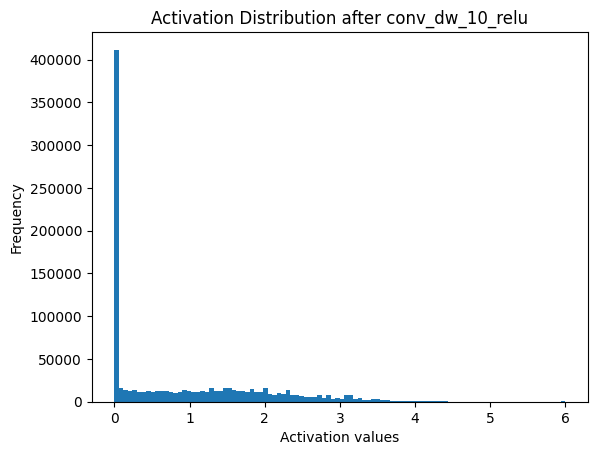

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
Layer: conv_pw_10_relu - Activation min: 0.0, max: 6.0


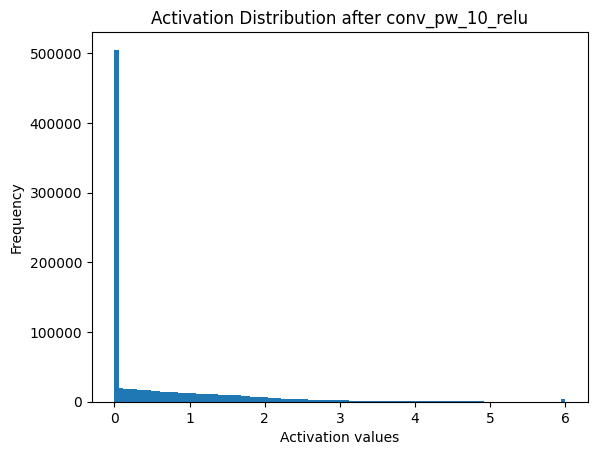

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
Layer: conv_dw_11_relu - Activation min: 0.0, max: 6.0


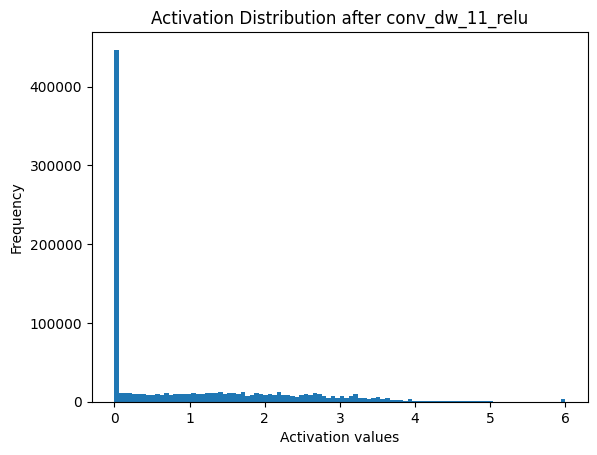

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
Layer: conv_pw_11_relu - Activation min: 0.0, max: 6.0


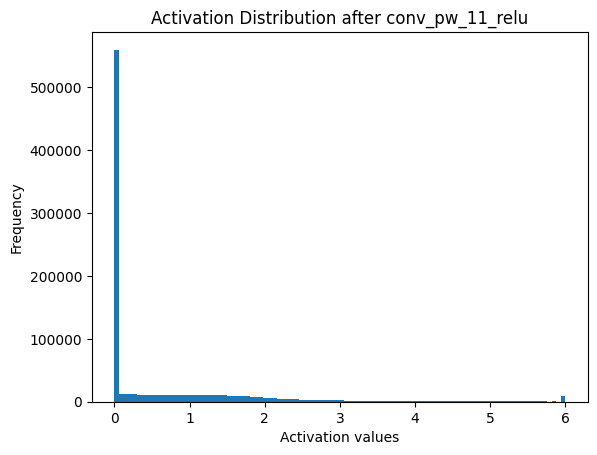

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
Layer: conv_dw_12_relu - Activation min: 0.0, max: 6.0


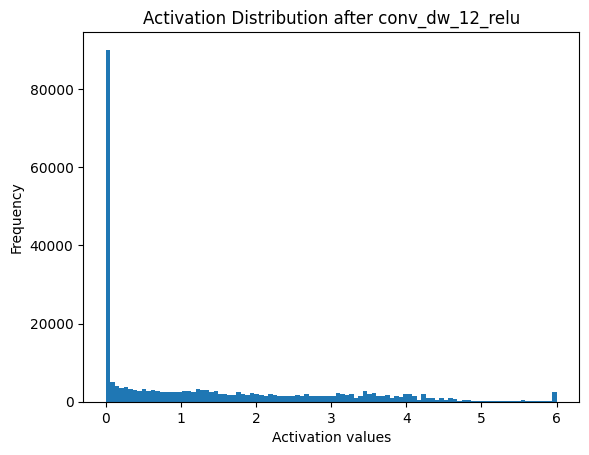

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
Layer: conv_pw_12_relu - Activation min: 0.0, max: 6.0


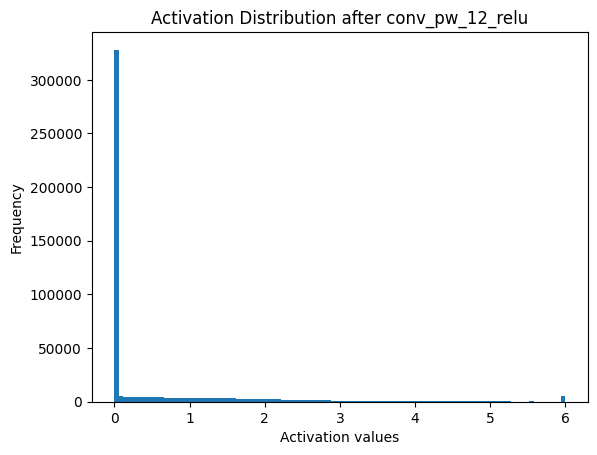

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_dw_13_relu - Activation min: 0.0, max: 6.0


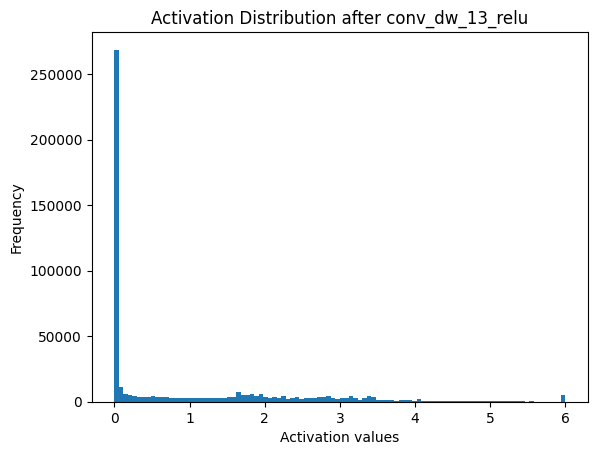

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
Layer: conv_pw_13_relu - Activation min: 0.0, max: 6.0


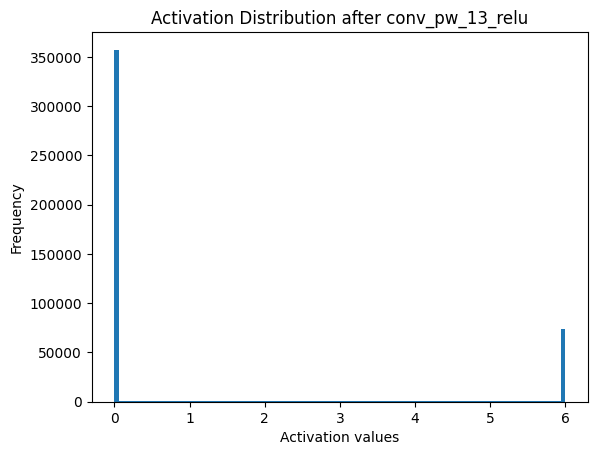

4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 16s/step - accuracy: 1.0000 - loss: 0.0028
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Layer: conv1_relu - Activation min: 0.0, max: 6.0


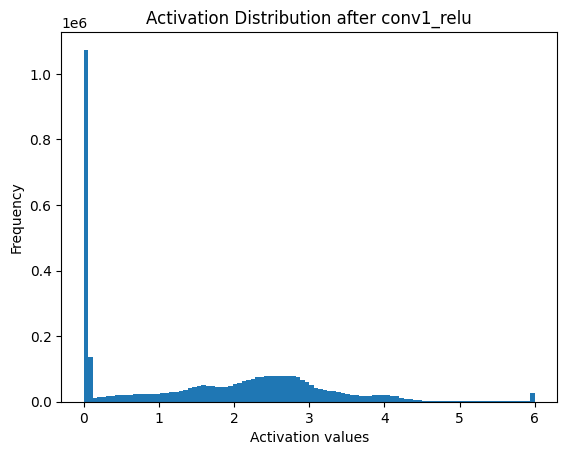

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Layer: conv_dw_1_relu - Activation min: 0.0, max: 6.0


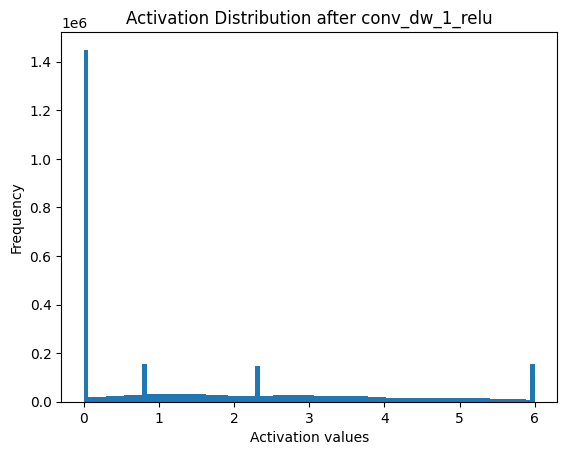

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Layer: conv_pw_1_relu - Activation min: 0.0, max: 6.0


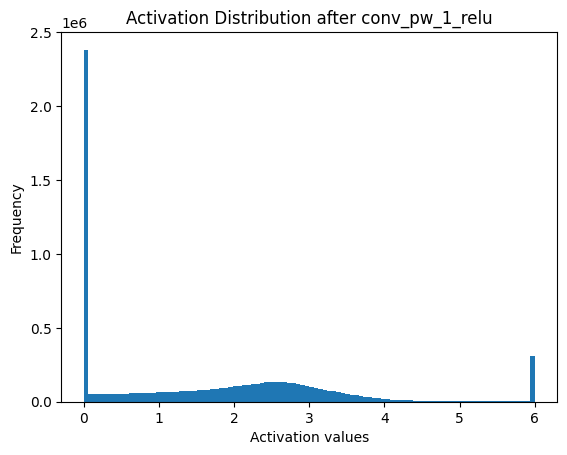

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Layer: conv_dw_2_relu - Activation min: 0.0, max: 6.0


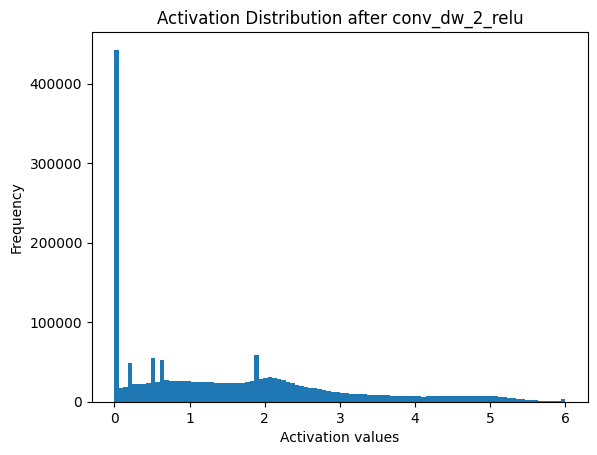

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Layer: conv_pw_2_relu - Activation min: 0.0, max: 6.0


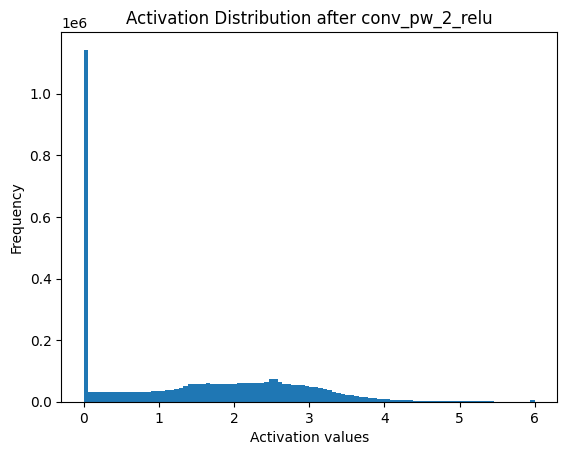

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Layer: conv_dw_3_relu - Activation min: 0.0, max: 6.0


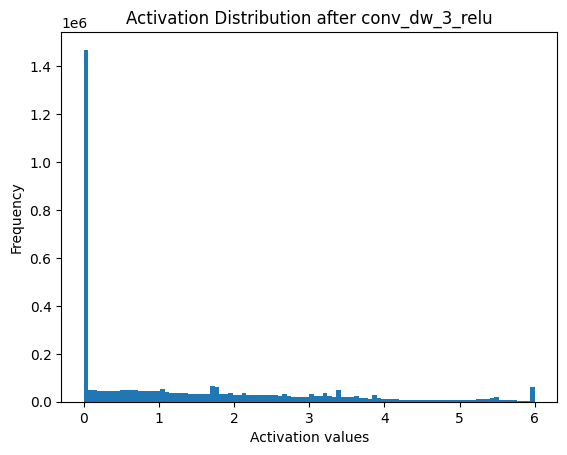

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Layer: conv_pw_3_relu - Activation min: 0.0, max: 6.0


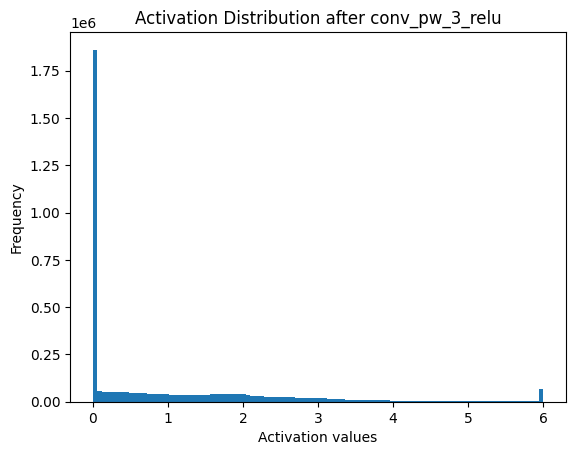

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Layer: conv_dw_4_relu - Activation min: 0.0, max: 6.0


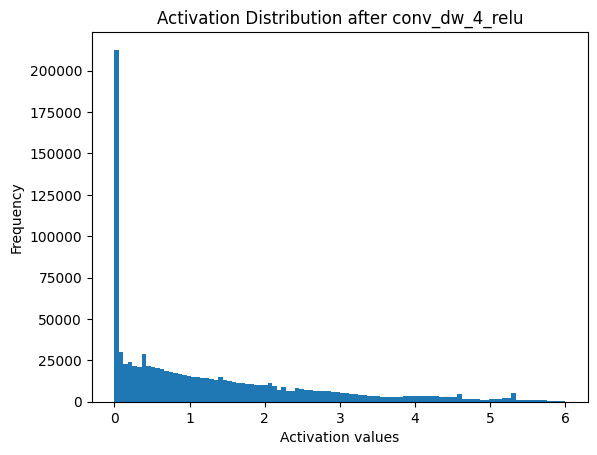

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Layer: conv_pw_4_relu - Activation min: 0.0, max: 6.0


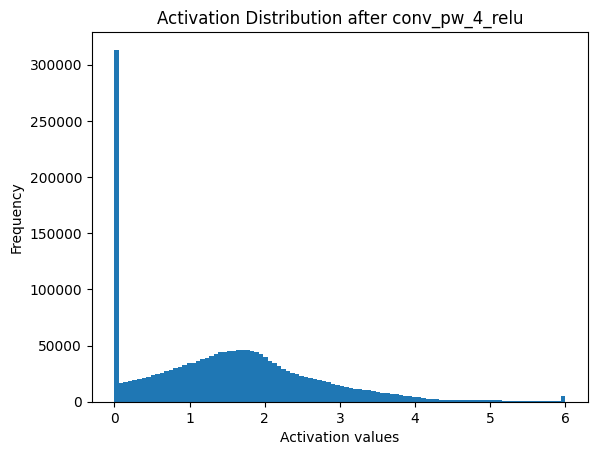

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Layer: conv_dw_5_relu - Activation min: 0.0, max: 6.0


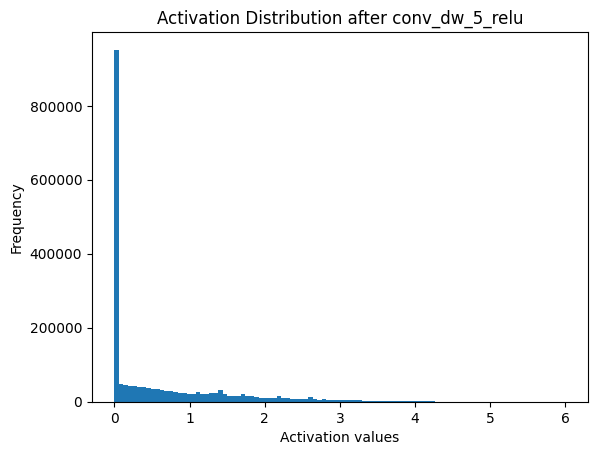

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
Layer: conv_pw_5_relu - Activation min: 0.0, max: 6.0


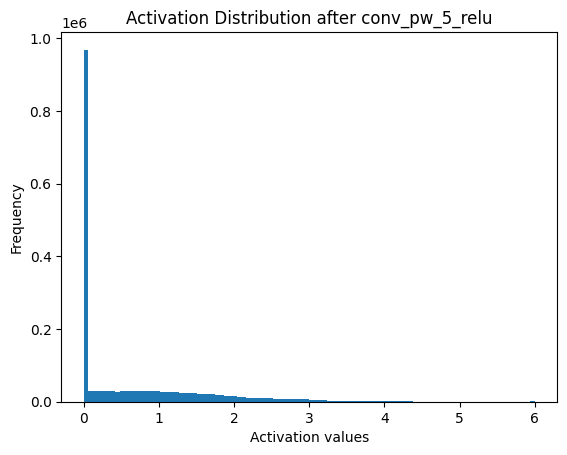

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Layer: conv_dw_6_relu - Activation min: 0.0, max: 6.0


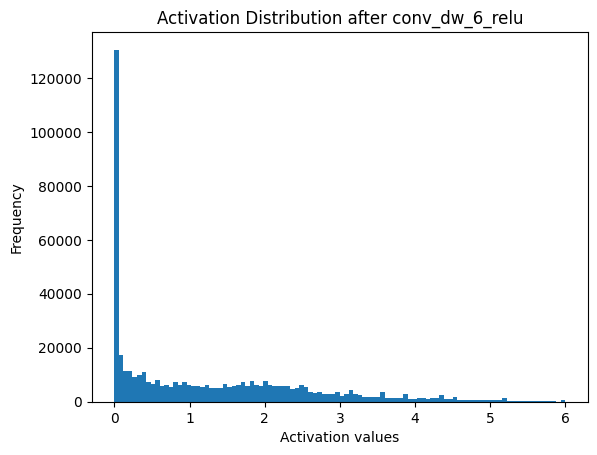

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Layer: conv_pw_6_relu - Activation min: 0.0, max: 6.0


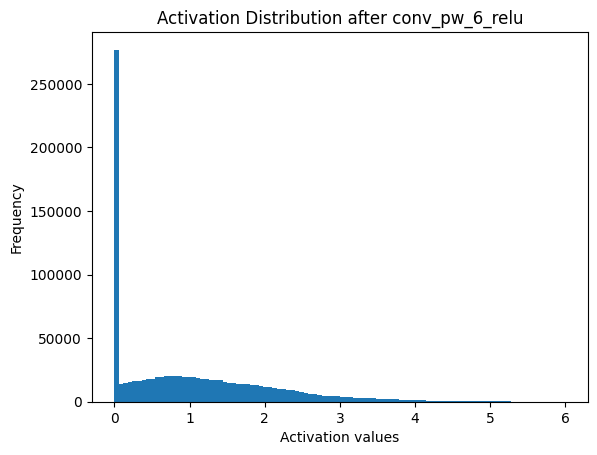

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Layer: conv_dw_7_relu - Activation min: 0.0, max: 6.0


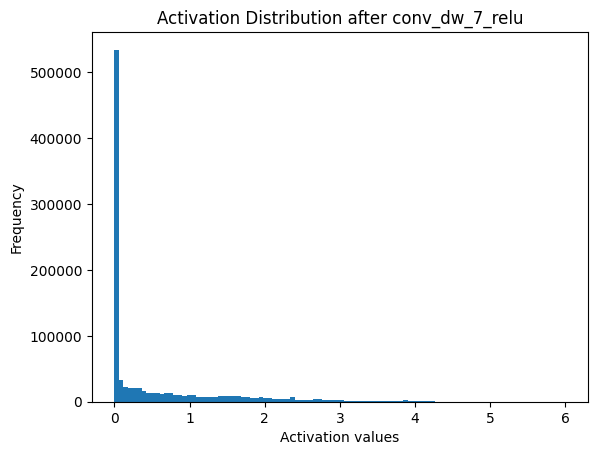

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Layer: conv_pw_7_relu - Activation min: 0.0, max: 6.0


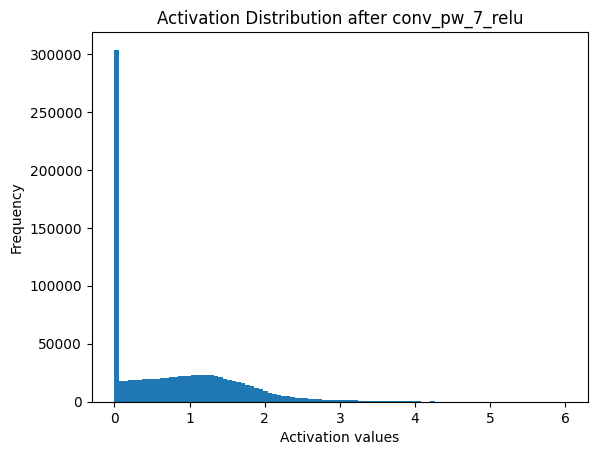

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Layer: conv_dw_8_relu - Activation min: 0.0, max: 6.0


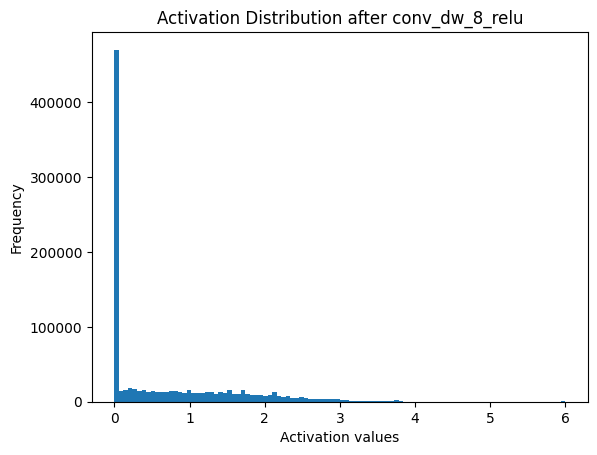

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Layer: conv_pw_8_relu - Activation min: 0.0, max: 6.0


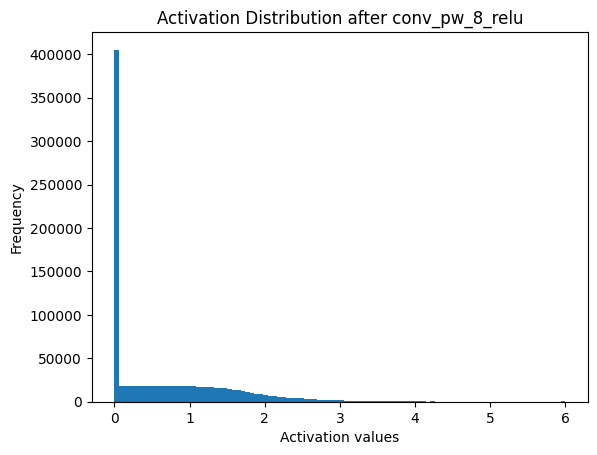

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Layer: conv_dw_9_relu - Activation min: 0.0, max: 6.0


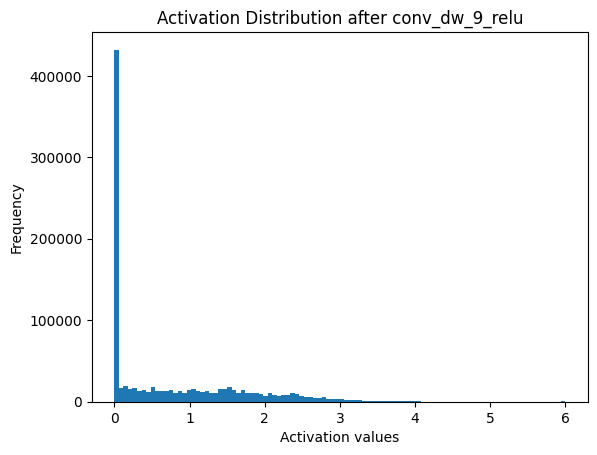

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Layer: conv_pw_9_relu - Activation min: 0.0, max: 6.0


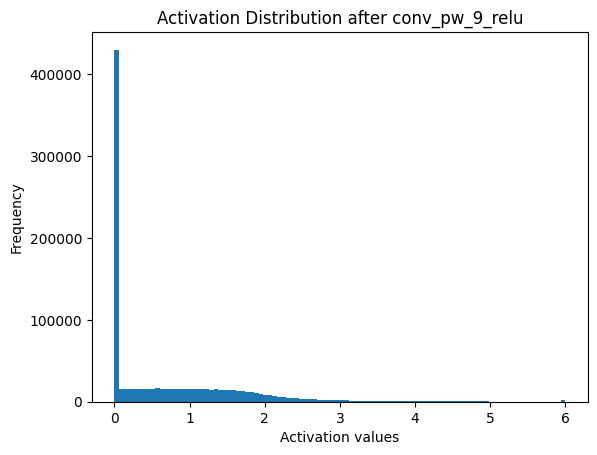

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_dw_10_relu - Activation min: 0.0, max: 6.0


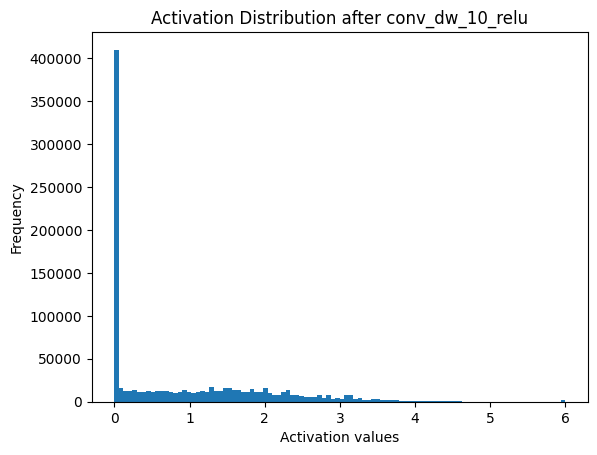

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Layer: conv_pw_10_relu - Activation min: 0.0, max: 6.0


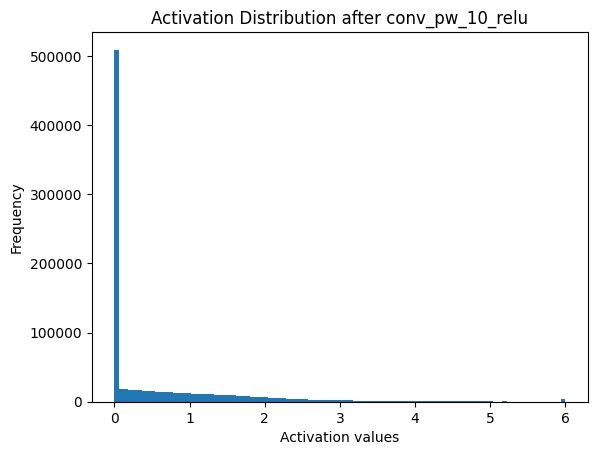

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
Layer: conv_dw_11_relu - Activation min: 0.0, max: 6.0


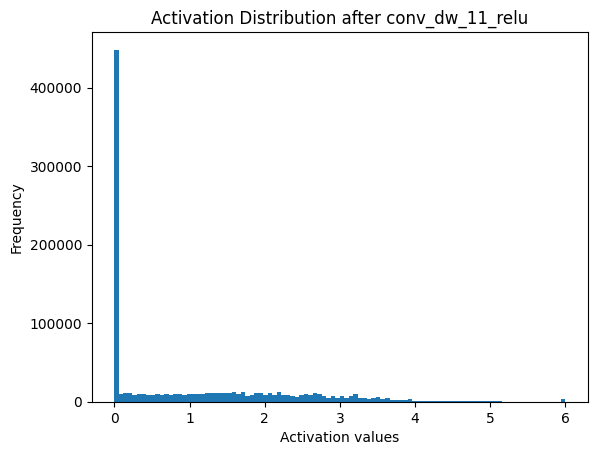

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
Layer: conv_pw_11_relu - Activation min: 0.0, max: 6.0


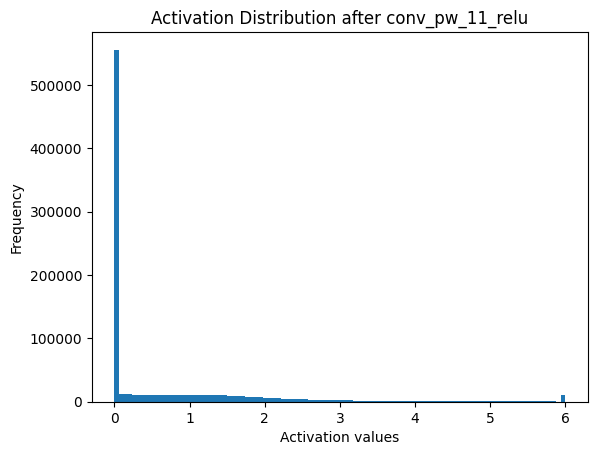

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
Layer: conv_dw_12_relu - Activation min: 0.0, max: 6.0


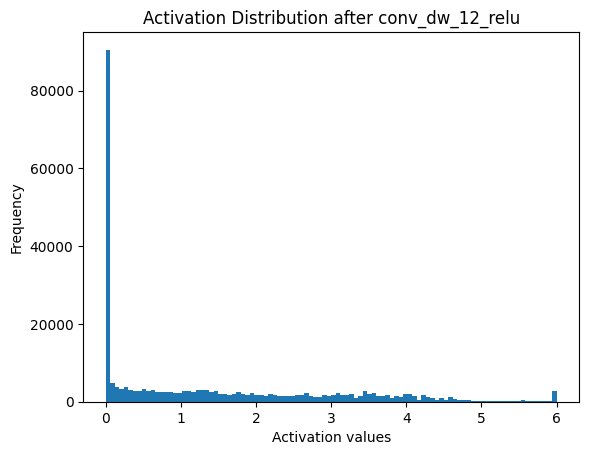

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
Layer: conv_pw_12_relu - Activation min: 0.0, max: 6.0


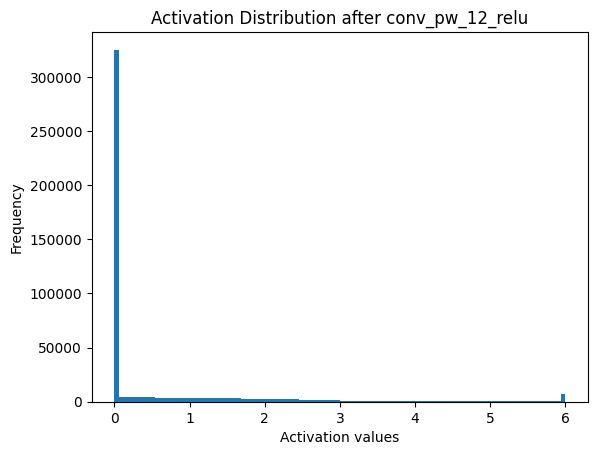

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Layer: conv_dw_13_relu - Activation min: 0.0, max: 6.0


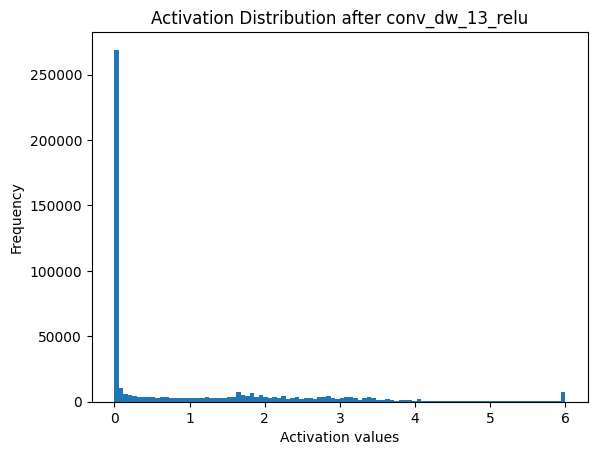

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Layer: conv_pw_13_relu - Activation min: 0.0, max: 6.0


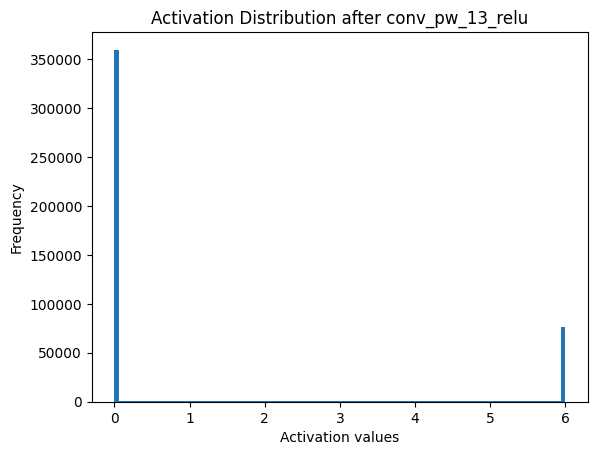

4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 1.0000 - loss: 0.0080
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Layer: conv1_relu - Activation min: 0.0, max: 6.0


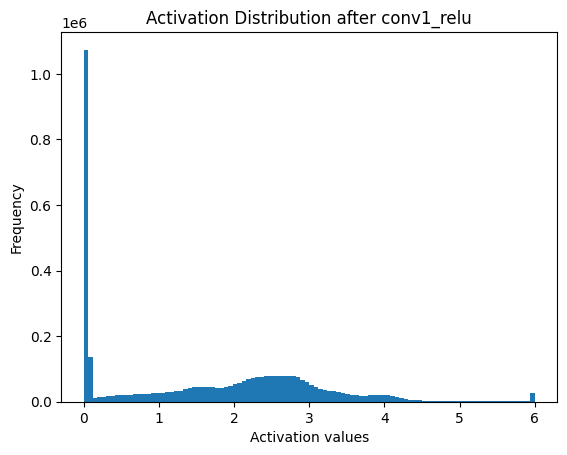

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Layer: conv_dw_1_relu - Activation min: 0.0, max: 6.0


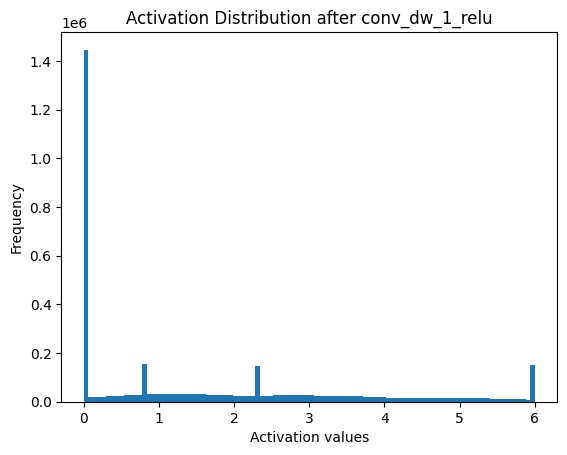

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Layer: conv_pw_1_relu - Activation min: 0.0, max: 6.0


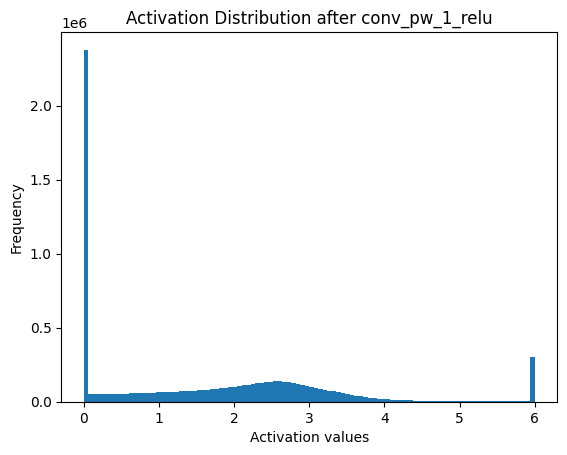

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Layer: conv_dw_2_relu - Activation min: 0.0, max: 6.0


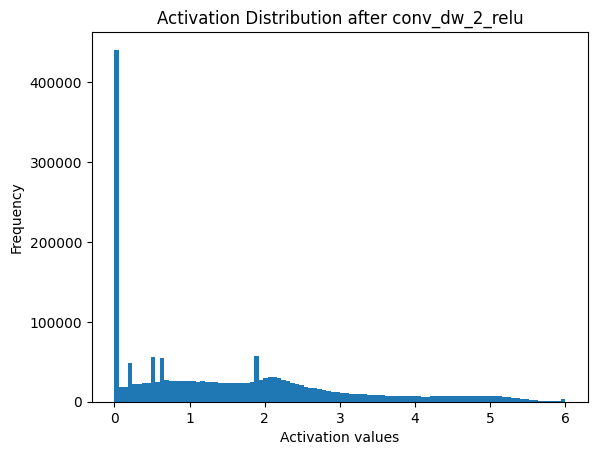

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Layer: conv_pw_2_relu - Activation min: 0.0, max: 6.0


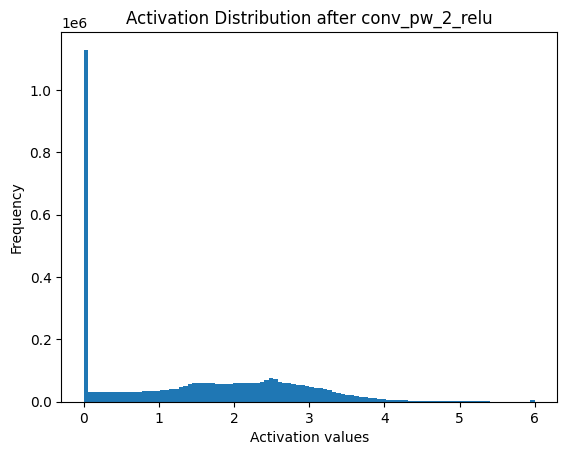

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Layer: conv_dw_3_relu - Activation min: 0.0, max: 6.0


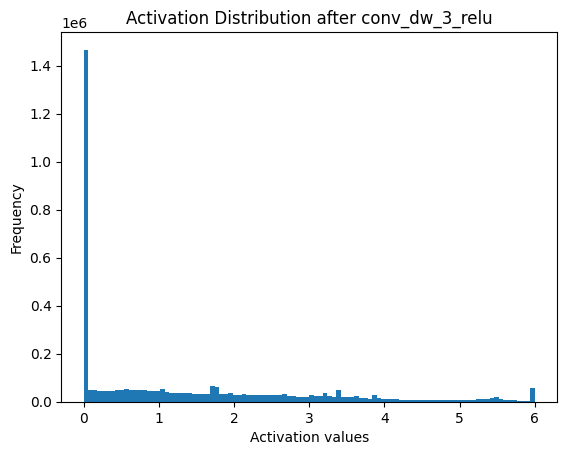

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Layer: conv_pw_3_relu - Activation min: 0.0, max: 6.0


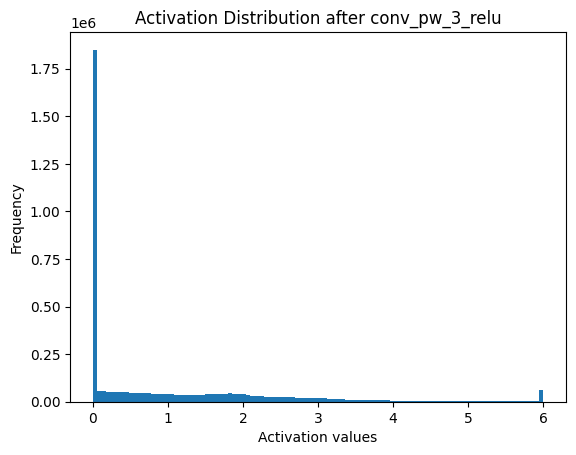

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Layer: conv_dw_4_relu - Activation min: 0.0, max: 6.0


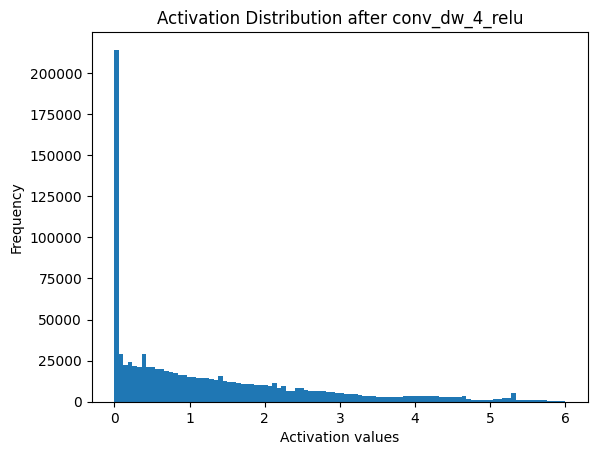

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Layer: conv_pw_4_relu - Activation min: 0.0, max: 6.0


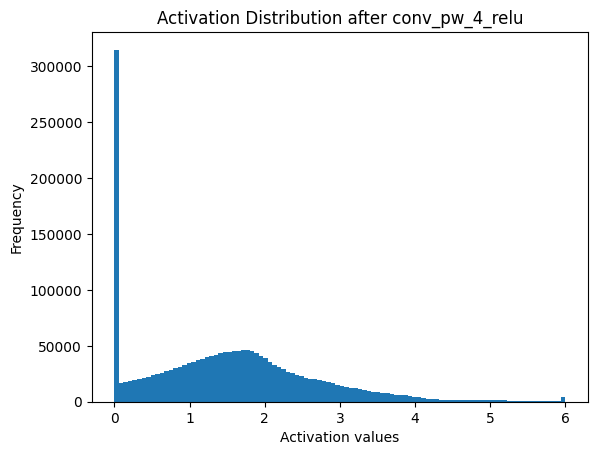

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Layer: conv_dw_5_relu - Activation min: 0.0, max: 6.0


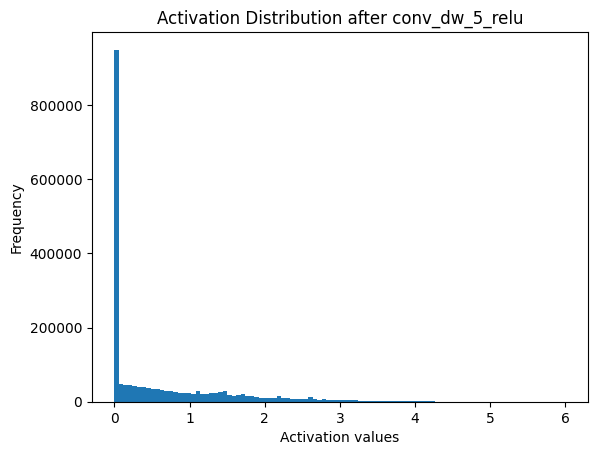

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Layer: conv_pw_5_relu - Activation min: 0.0, max: 6.0


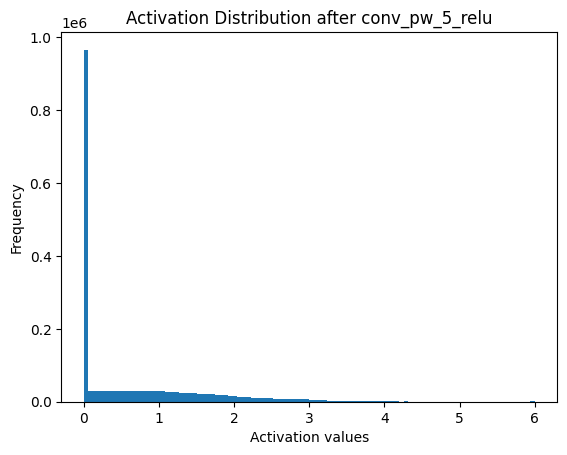

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Layer: conv_dw_6_relu - Activation min: 0.0, max: 6.0


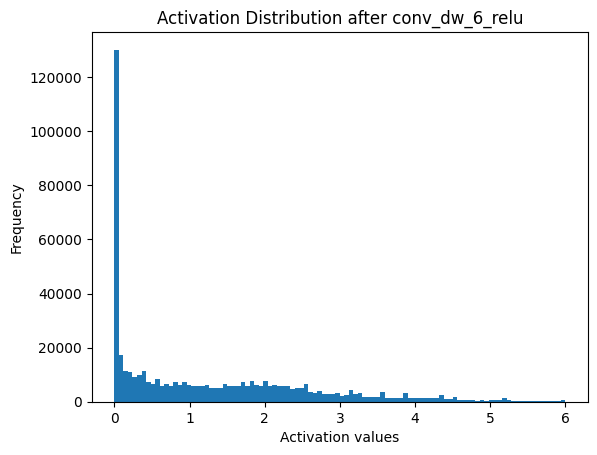

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
Layer: conv_pw_6_relu - Activation min: 0.0, max: 6.0


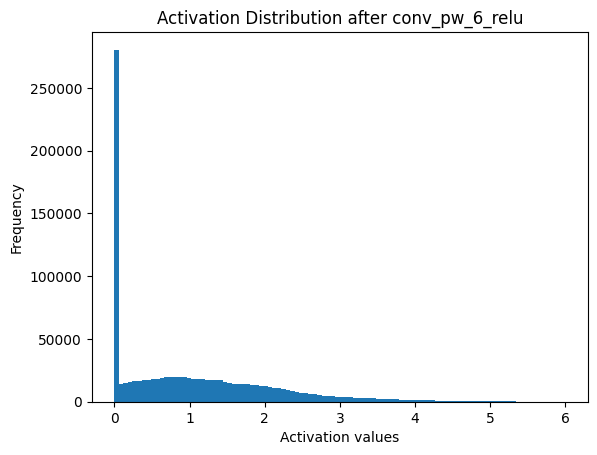

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
Layer: conv_dw_7_relu - Activation min: 0.0, max: 6.0


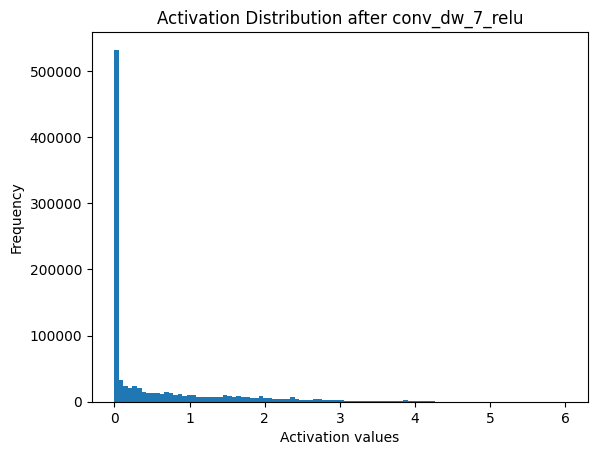

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Layer: conv_pw_7_relu - Activation min: 0.0, max: 6.0


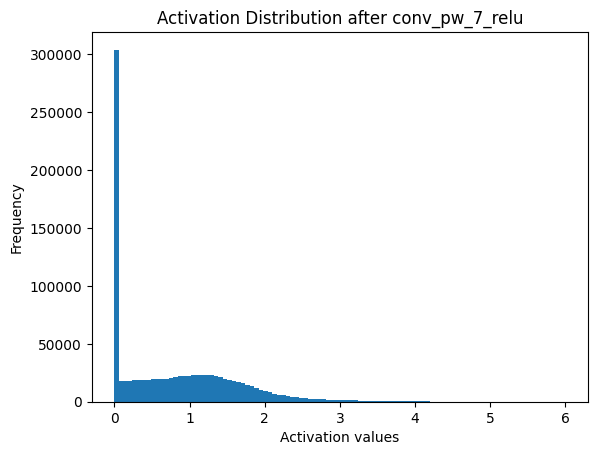

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Layer: conv_dw_8_relu - Activation min: 0.0, max: 6.0


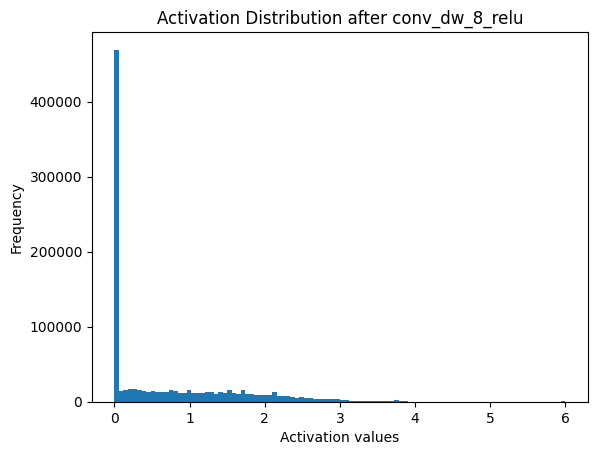

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Layer: conv_pw_8_relu - Activation min: 0.0, max: 6.0


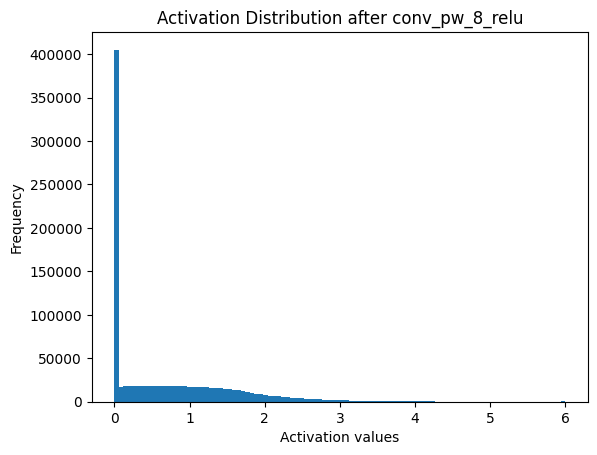

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Layer: conv_dw_9_relu - Activation min: 0.0, max: 6.0


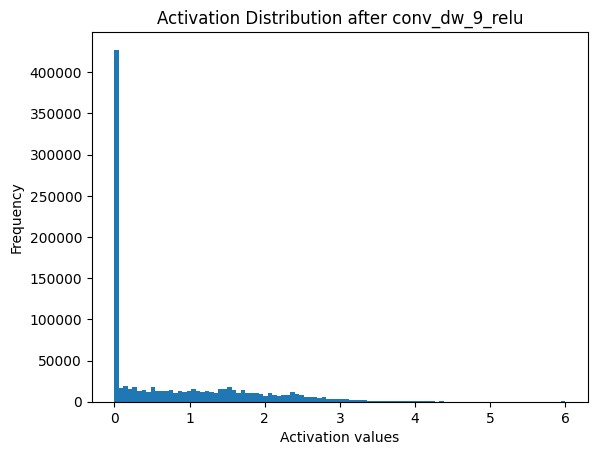

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Layer: conv_pw_9_relu - Activation min: 0.0, max: 6.0


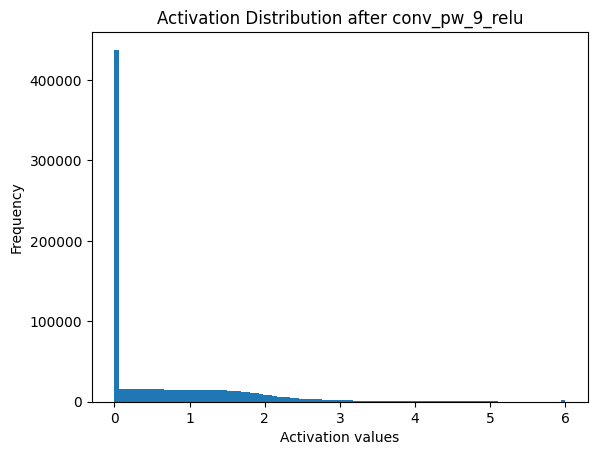

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Layer: conv_dw_10_relu - Activation min: 0.0, max: 6.0


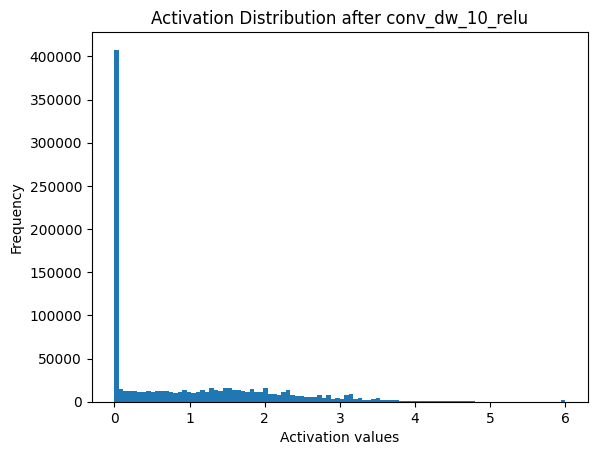

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer: conv_pw_10_relu - Activation min: 0.0, max: 6.0


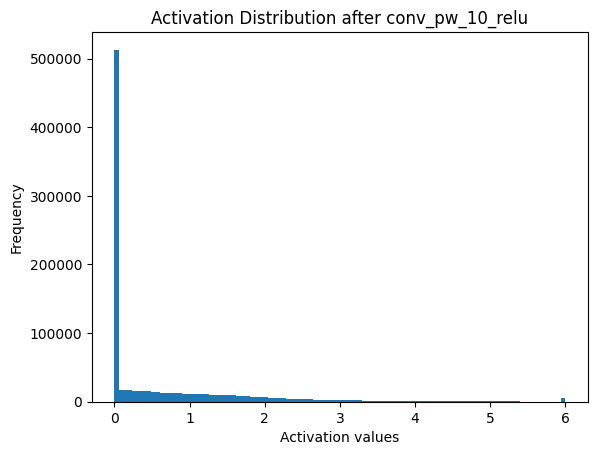

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
Layer: conv_dw_11_relu - Activation min: 0.0, max: 6.0


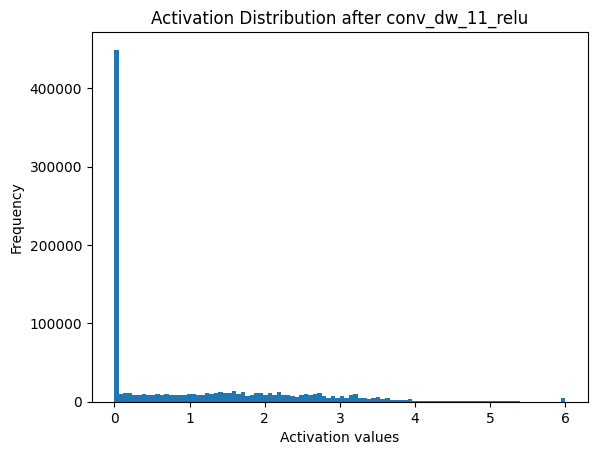

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
Layer: conv_pw_11_relu - Activation min: 0.0, max: 6.0


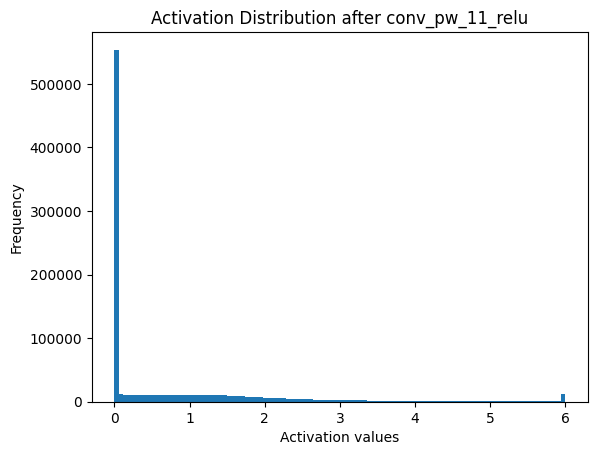

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
Layer: conv_dw_12_relu - Activation min: 0.0, max: 6.0


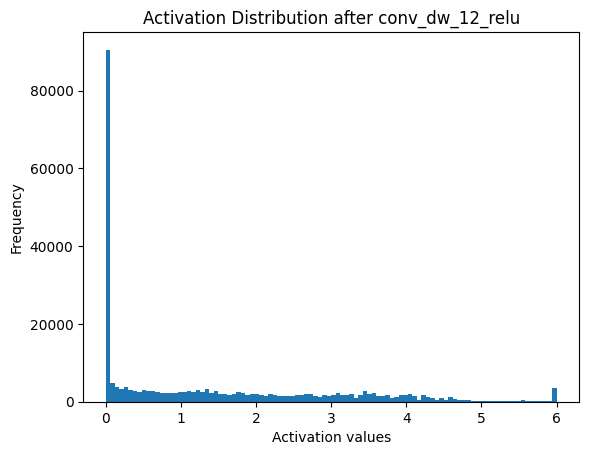

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
Layer: conv_pw_12_relu - Activation min: 0.0, max: 6.0


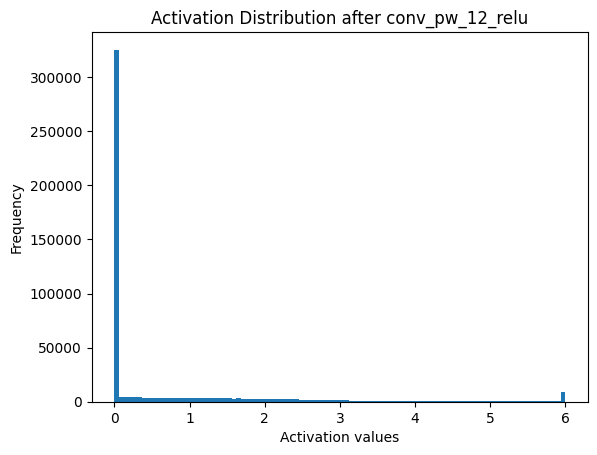

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
Layer: conv_dw_13_relu - Activation min: 0.0, max: 6.0


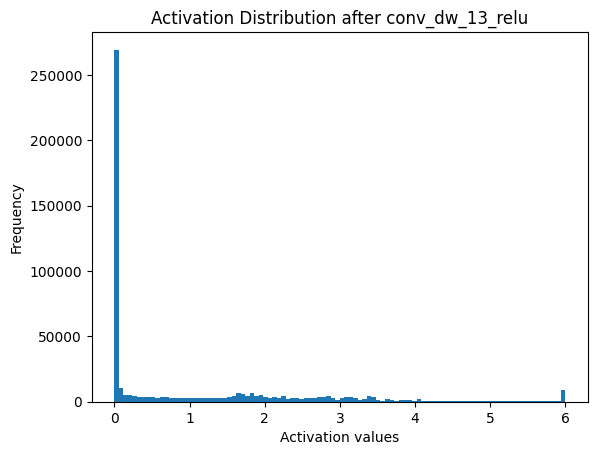

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
Layer: conv_pw_13_relu - Activation min: 0.0, max: 6.0


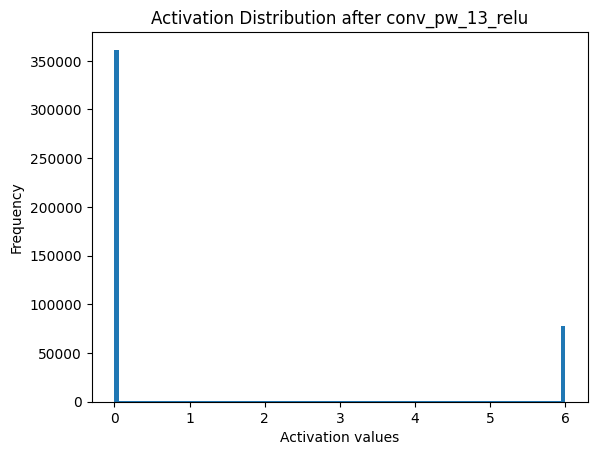

4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 15s/step - accuracy: 1.0000 - loss: 0.0107


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
import numpy as np
import matplotlib.pyplot as plt

# Define a custom callback to monitor activations at each layer
class ActivationMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
         # Print the ReLU6 activation output
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.ReLU):  # Find ReLU layers
                activation_model = tf.keras.Model(inputs=self.model.input, outputs=layer.output)
                # Select a small batch of input data for prediction to get the activations
                activations = activation_model.predict(x_train[:10])  # Monitor only the first 10 samples
                print(f"Layer: {layer.name} - Activation min: {activations.min()}, max: {activations.max()}")
                # Visualize the distribution of activations
                plt.hist(activations.flatten(), bins=100)
                plt.xlabel("Activation values")
                plt.ylabel("Frequency")
                plt.title(f"Activation Distribution after {layer.name}")
                plt.show()

# Load the MobileNetV1 model
model = MobileNet(alpha=1.0,  # MobileNet paper width parameter
                  include_top=True,    # Include the final fully connected layer
                  weights='imagenet',  # Use pre-trained weights from ImageNet
                  classes=1000)        # ImageNet has 1000 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generate some random data for training the model
x_train = np.random.rand(100, 224, 224, 3)  # Assuming 100 RGB images of size 224x224
y_train = np.random.randint(0, 1000, size=(100,))  # Assuming 100 labels, with 1000 classes

# Train the model and add the monitoring callback
history = model.fit(x_train, y_train, epochs=5, callbacks=[ActivationMonitor()])


The code above visualizes the activation values of each layer during training in real time. In the internal layers, the imformation performs well and not much loss. However, in the final layer, the information has lost severely.

Epoch 5
start:
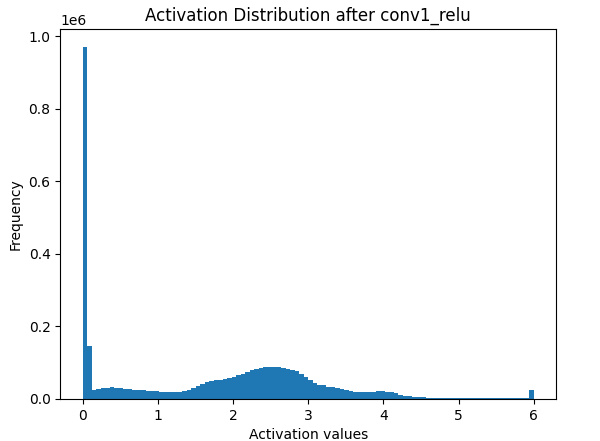 \\
final:
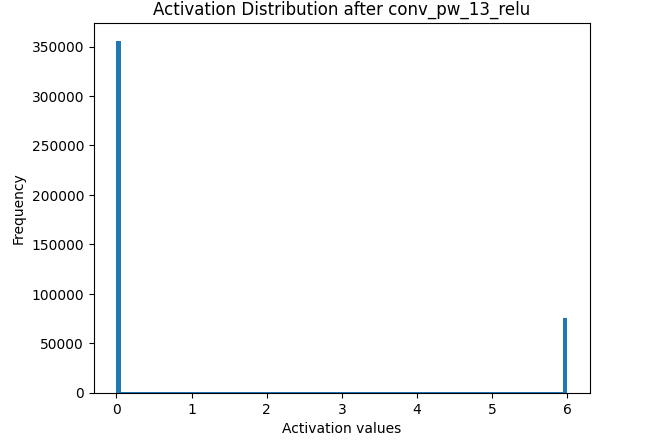

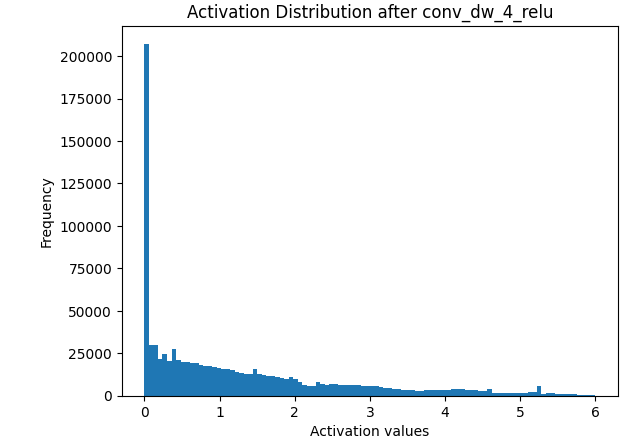

Second limitation is that after trainning, most of the parameters are zero. The figure here is the weight distribution of the layer 15. We could see that the values are centered around 0 and have a peak at weight = 0.

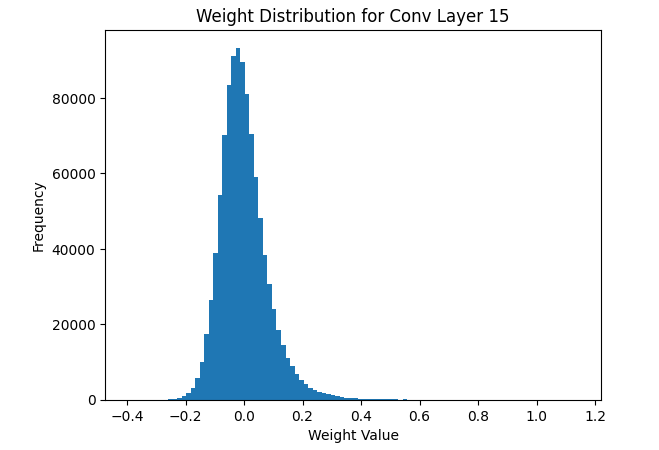

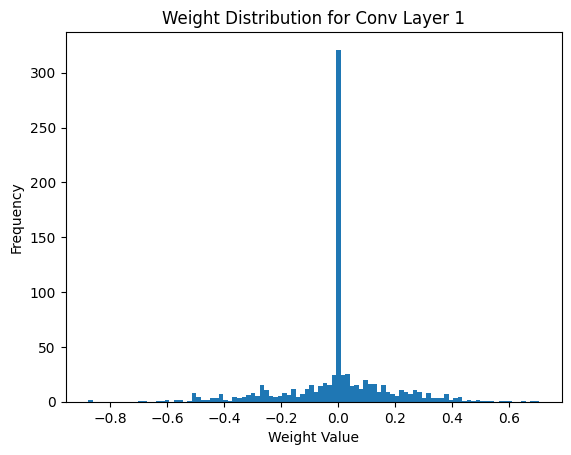

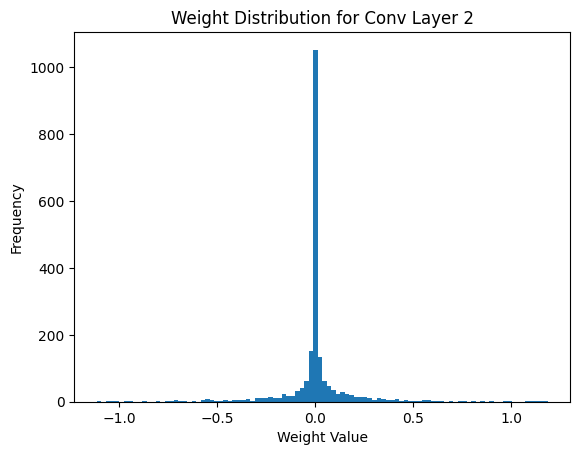

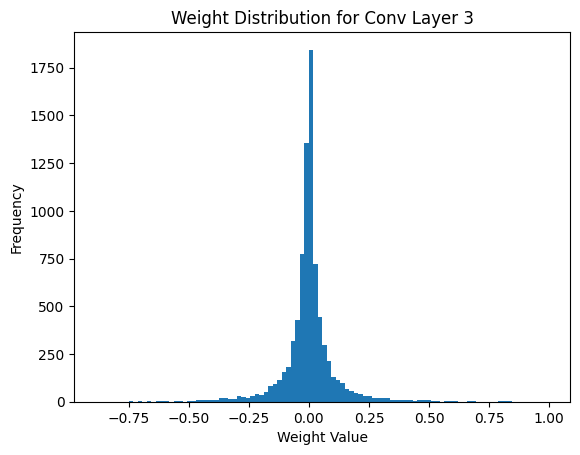

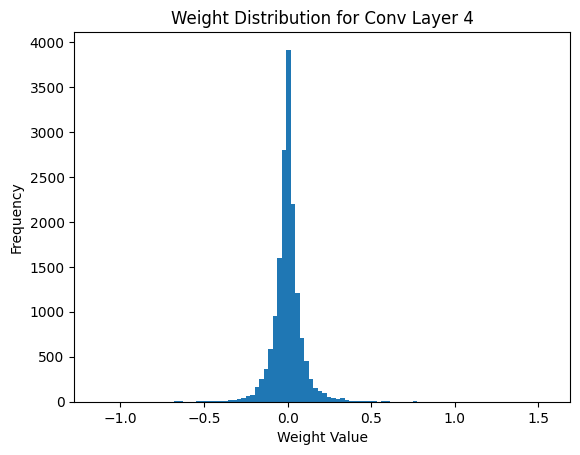

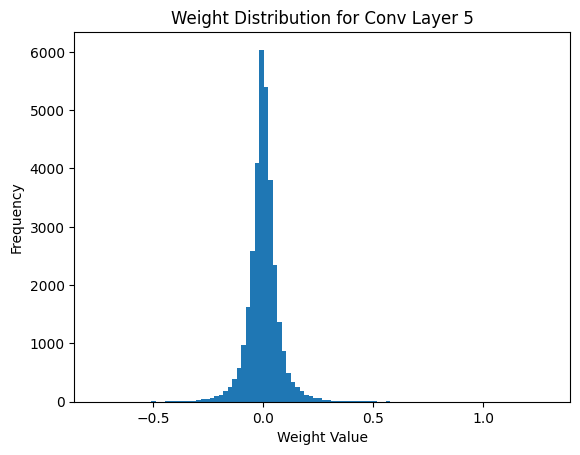

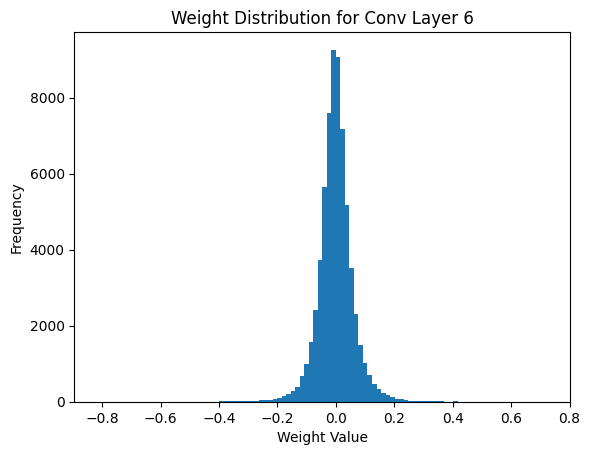

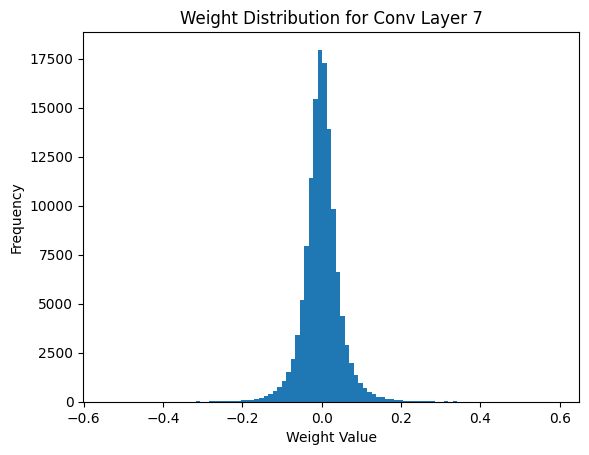

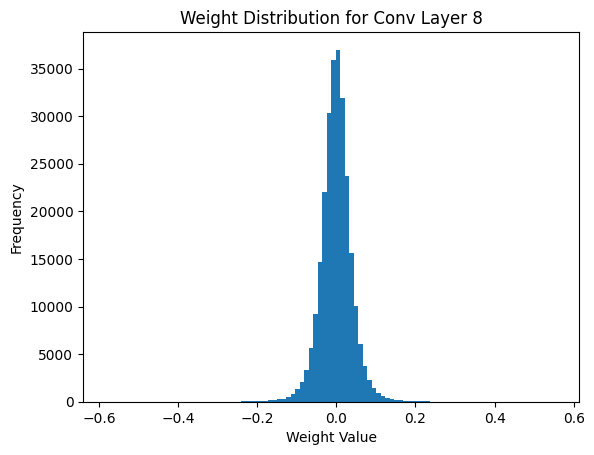

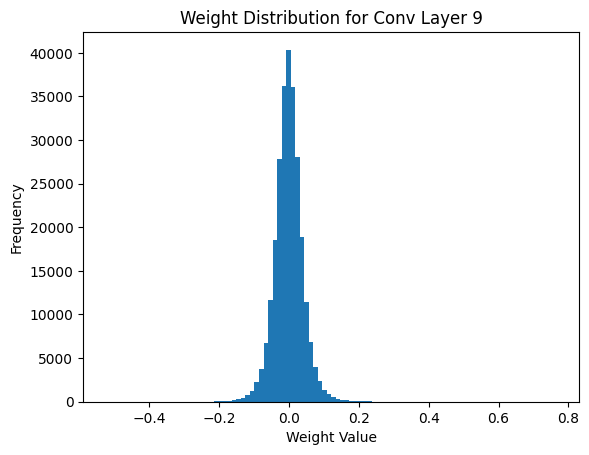

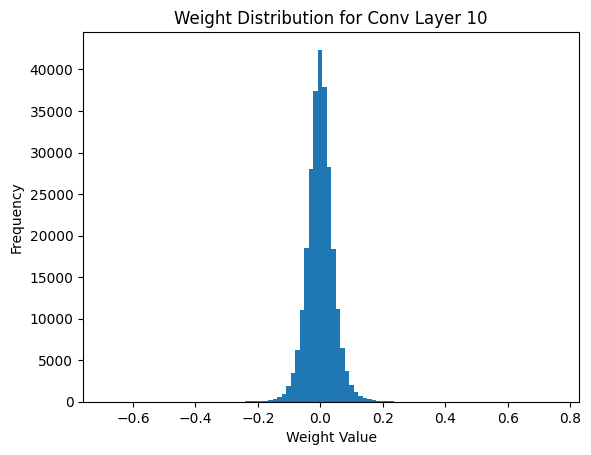

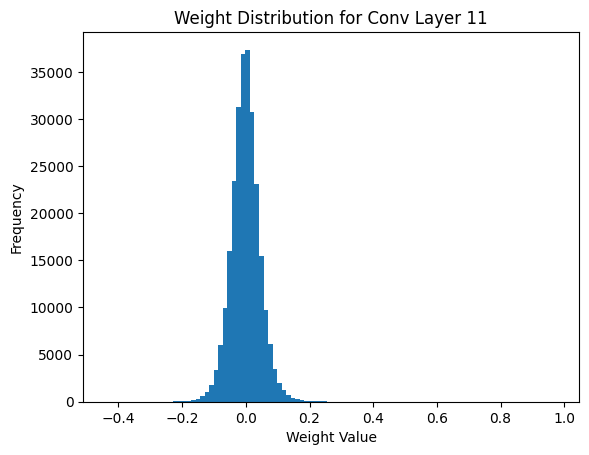

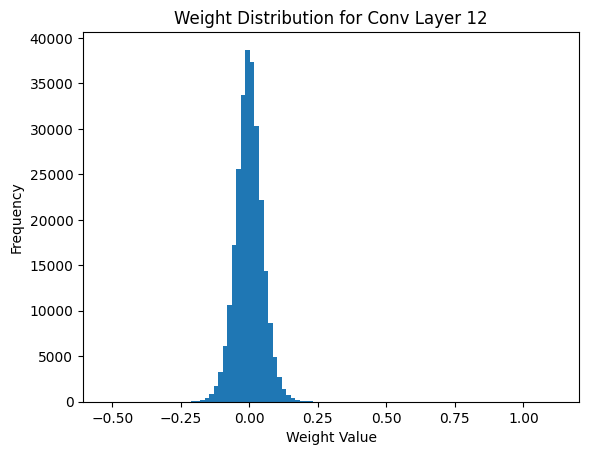

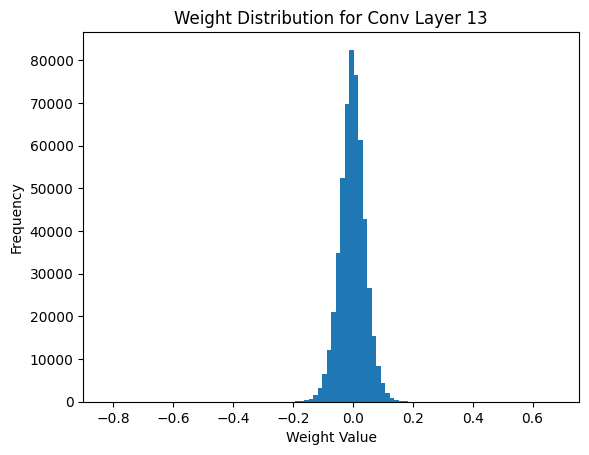

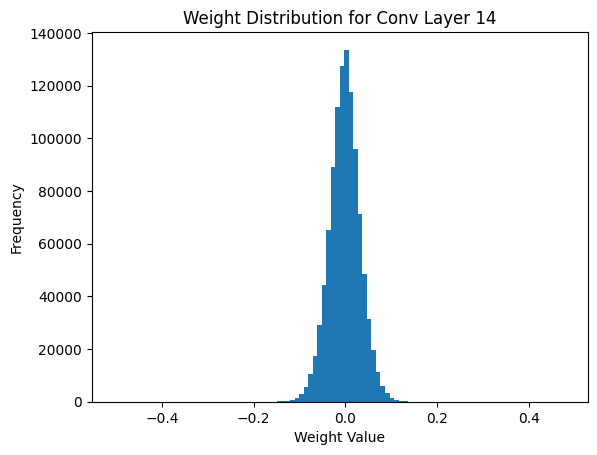

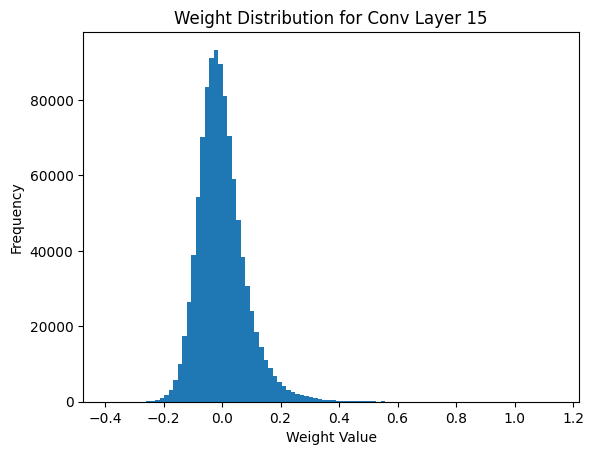

In [ ]:
#the code here shows the weight distribution of each layer.

import tensorflow as tf
import numpy as np

# Load the MobileNetV1 model
model = tf.keras.applications.MobileNet(alpha=1.0, include_top=True, weights='imagenet', classes=1000)

# Extract convolutional layer weights
conv_weights = []

# Iterate through all layers in the model and find convolutional layers
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_weights.append(layer.get_weights()[0])  # Get the weights of the convolutional layer

# Display the weight statistics
for i, weights in enumerate(conv_weights):

    # Optional: Visualize the weight distribution of a convolutional layer
    import matplotlib.pyplot as plt
    plt.hist(weights.flatten(), bins=100)
    plt.title(f"Weight Distribution for Conv Layer {i+1}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()


These could be fixed by the methodologies below.

The paper has also conducted the ablation study of the inverted residual connections and the importance of the linear bottlenecks. The figure below is the impact of non-linearities and various types of shortcut connections.

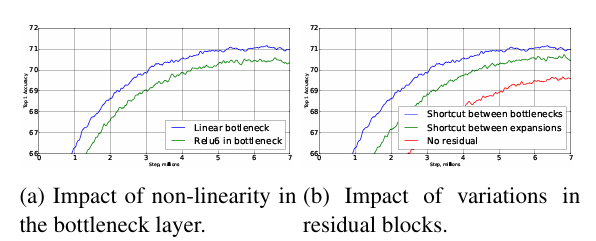

In figure (a), it compares the performance of linear bottleneck and ReLU6 bottleneck. From the figure we could conclude that the linear bottleneck has a better performance with a lower convergence speed. \\

In figure (b), it compares the performance of three conditions: without residual, residual between bottlenecks and between expansions. From the figure we could conclude that the shortcut between bottlenecks has the best performance with the lowest convergence speed.

##Lemma 1 proof


The paper has proved that the bottleneck transformation is invertable, which means, we could map every $y$ transformed by this methodology to the input x, to be more specific, to prove that if this method could cause the imformation loss. \\
In our bottleneck transformation, we first expand the input $x$ with n channels by a standard convolution, in the mathmatical way, a $m$ x  $n$  $T$ matrix. And after expansion we conduct a ReLU change. Then we decrease the dimensions by a $n$ x $m$ $T^{-1}$ matrix. It also could be illustrated by the figure below: \\



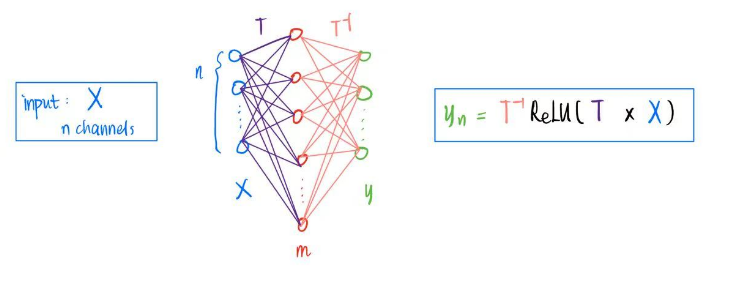

The arguement is that, if m $\leq$ n, transformations of this form can only exploit non-linearity at the cost of losing information. In contrast, if n $\ll$ m, such transforms can be highly non-linear but still invertible with high probability (for the initial random weights). \\
In other words, in the function of: \\
$y_{n} = T_{n \times m}^{-1} ReLU (T_{m \times n} \times X_{n})$, \\
how could we choose m to let there is one solution of the function, i.e., each single $y_n$ could map only one $x$, which means the information doesn't lose. \\
It first shows two lemma:

Lemma 1: Let $S(X) = (ReLU(x)|x \in X). \text{ If a volume of }S(X) \text{is non-zero, then interior } S(X) \subseteq X. $ \\
This lemma means that, in the ReLU transformation, for the part of non-zero of X, it is a linear transformation, which could be a minor contributor to the power of the deep networks. \\
And for the part of negative part of X, then comes to the lemma 2.

###conclusion of lemma 1 and 2

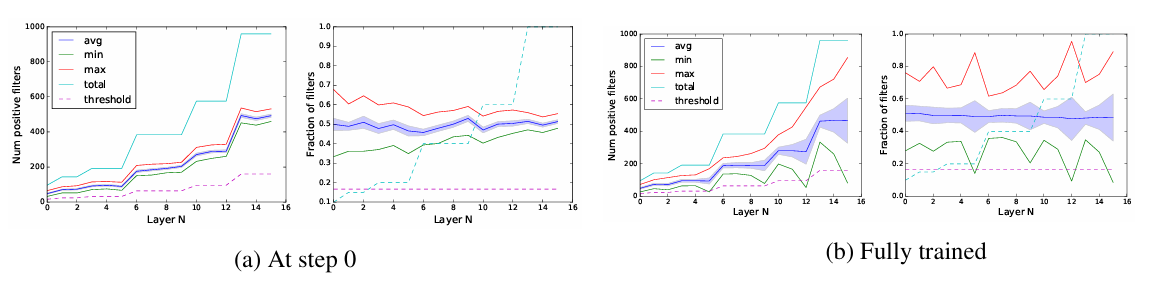

This figure is the Distribution of activation patterns. The x-axis is the layer index, and we show minimum/maximum/average number of positive channels after each convolution with ReLU. y-axis is either absolute or relative number of channels. The“threshold”line indicates the ReLU invertibility threshold - if the line is below this threhold, it means the information has lost. In our case this is 1/6 fraction of the channels. \\
To be more specific, for the left one in figure(a), it is the amount of the feature map that activated as positive, the right one is the fraction of the feature that activated as positive. we could see that the distribution is to some extend, symmetric and centered. This is because before training, all the parameters are randomly initialized. \\
After training in figure(b), the standard deviation grew dramatically. The min line are mostly above the threhold line, with several below. This also means that most of the layers of MobileNetV2 are invertiable.

##Relevance and Significance:


**1. Reduced Computational Load and Parameter Count:** MobileNetV2 is a lightweight net with a minimal computational load and reduced parameter count. This characteristic makes it highly relevant for mobile devices and edge computing applications, where computational resources are limited. \\

**2. High Performance:** Despite its lightweight nature, MobileNetV2 does not compromise on performance. The use of efficient building blocks such as depthwise separable convolutions and linear bottleneck layers enables MobileNetV2 to strike a balance between high performance and low resource usage. Figure 5 further illustrates that MobileNetV2 delivers impressive results, outperforming many other lightweight models, making it an excellent choice for deploying deep learning models in resource-constrained environments without sacrificing performance. \\

The figure below shows the performance curve comparison between various network architectures, and different hyperparameters settings $(\alpha, \rho)$ clearly demonstrates MobileNetV2’s superior computational efficiency, making it an attractive choice for mobile applications that require quick processing and low power consumption.

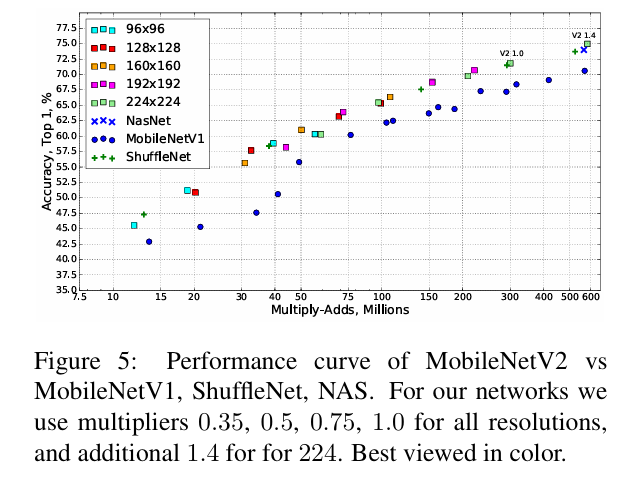

**3.Memory efficient inference:**  \\
TensorFlow or Caffe, could build a directed acyclic computed hypergraph G, this G consists of edges(intermediate computation) and nodes(tensors). \\
The computation is scheduled in order to minimize the total number of tensors that needs to be stored in memory. In the most general case, it searches over all plausible computation orders $∑(G)$ and picks the one that minimize:
$M(G) = min_{π∈∑(G)} \quad max_{i \in 1...n} [\sum_{A \in R(i,\pi,G)}|A|] + size(\pi_i)$ \\
which is minimize the maximum bottleneck need to be stored in memory. $max_{i \in 1...n}[\sum_{A \in R(i,\pi,G)}|A|]$ means the maximum tensor in all the nodes. \\
For the graphs that has residual connections, there is only one feasible computation order, and $M(G)$ can be simplified:

$$
M(G) = \max_{op \in G} \left( \sum_{A \in op_{inp}} |A| + \sum_{B \in op_{out}} |B| + |op| \right)
$$

$\sum_{A \in op_{inp}} |A|$ represents the tensor in the input, $sum_{B \in op_{out}} |B|$ represents the tensor in output and $|op|$ represents the tensors in the intermediate layers. \\
As the amount of memory is determined by the maximum total size of combined inputs and outputs across all operations. The paper shows that the total amount of memory is dominated by the size of the bottleneck tensors, not the tensors that are internal to the bottleneck(expansion tensors). This could significantly increase the memory efficiency. \\
Besides, each layer of the model structure has used Average pooling layer instead of fully connected layer, which also decrease the computation cost.

##Limitation:




**Trade-off of the Parameters:** A key limitation of MobileNetV2 is that it still requires further testing to confirm whether the use of 3x3 convolutions is indeed the optimal solution. Other convolutional configurations may provide better trade-offs between computational efficiency and accuracy, and future experiments are needed to validate the current approach. \\

**ReLU6 Activation Function:** The ReLU6 activation function, which is used in MobileNetV2 for its bounded output, could potentially limit the model's accuracy. While it improves the stability of the model in low-resource settings, its performance may not be as high as other activation functions. To address this limitation, future optimizations could explore using the HS (Hard-Swish) function and SE (Squeeze-and-Excitation) module. These adjustments could help improve the model's expressiveness and accuracy, particularly in tasks requiring higher precision.

##Application, Extensions

The paper has conducted experiments on ImageNet dataset, with a good performance; and objection detection task-COCO dataset with an improvement in both accuracy and model complexity using SSDLite. \\
For possible applications of the methodology, it may be used in the area of real-time video processing, such as
live video object detection or autonomous vehicles; or loT devices, such as drones, smart cameras, or robotics, where low latency and power efficiency are crucial. \\
For further extensions, it could offer more robust transfer learning capabilities. This would allow the model to be adapted for domain-specific tasks such as medical image analysis, where it could achieve high performance with minimal retraining. Or it could be extended for multi-task learning, where a single model handles multiple tasks simultaneously, such as object detection and segmentation. This would be valuable for applications that require both object identification and detailed spatial analysis, such as in augmented reality or scene understanding.